2021-11-19 04:41:51.552375
當前工作目錄 ==> D:\0_sdr\SSNP3D\2_dir
Left Down point: 0 0
Right Up point:  4000 7800
height (min, max) 0.0 357.21










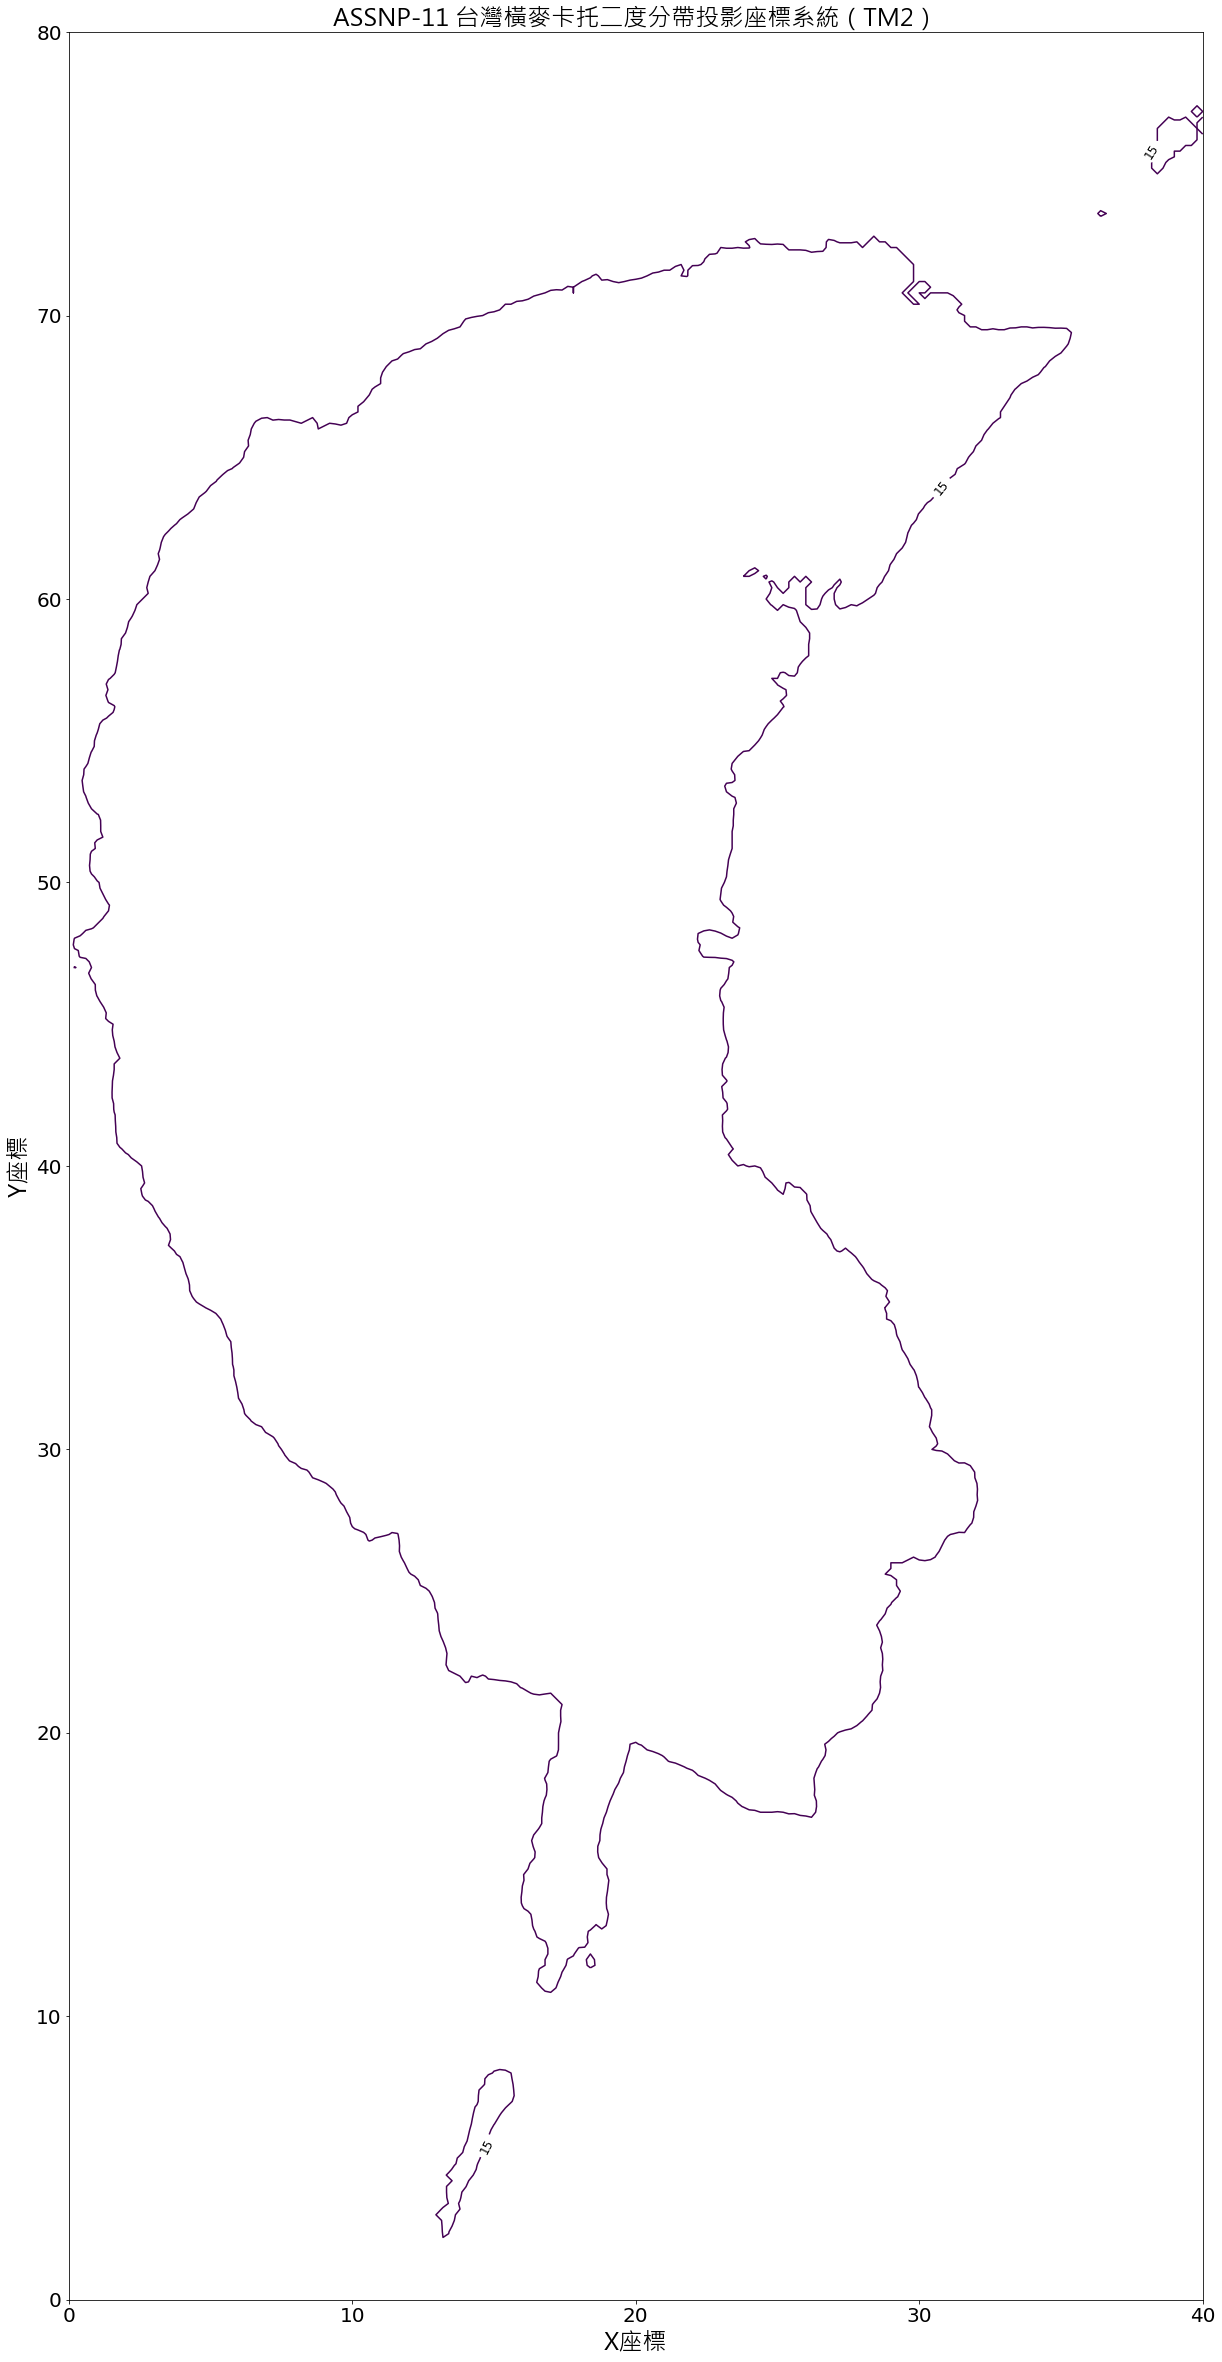

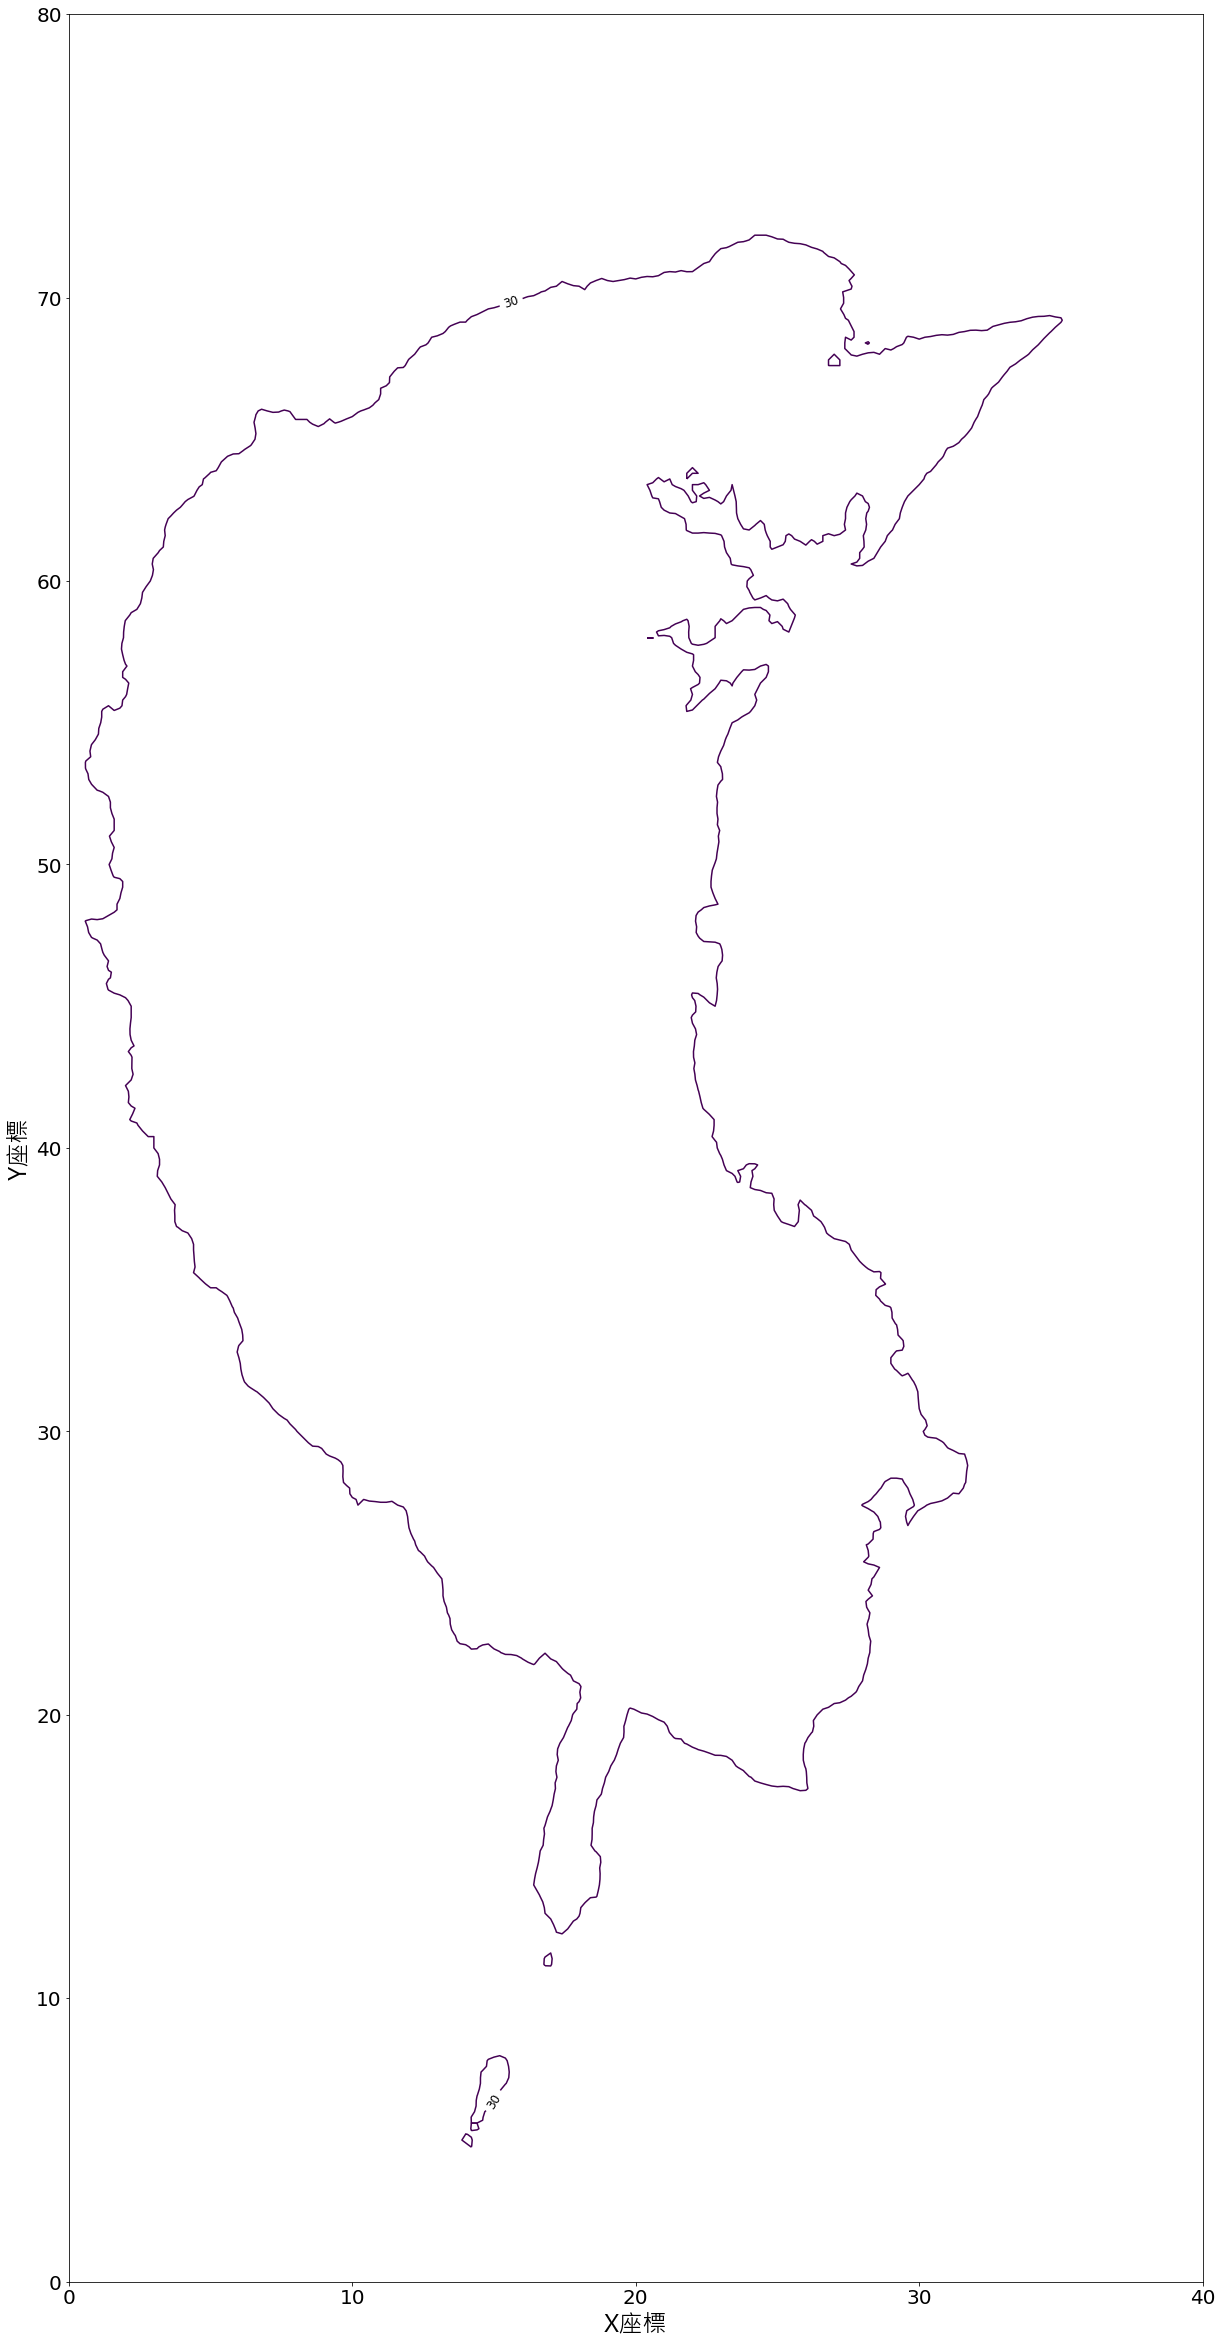

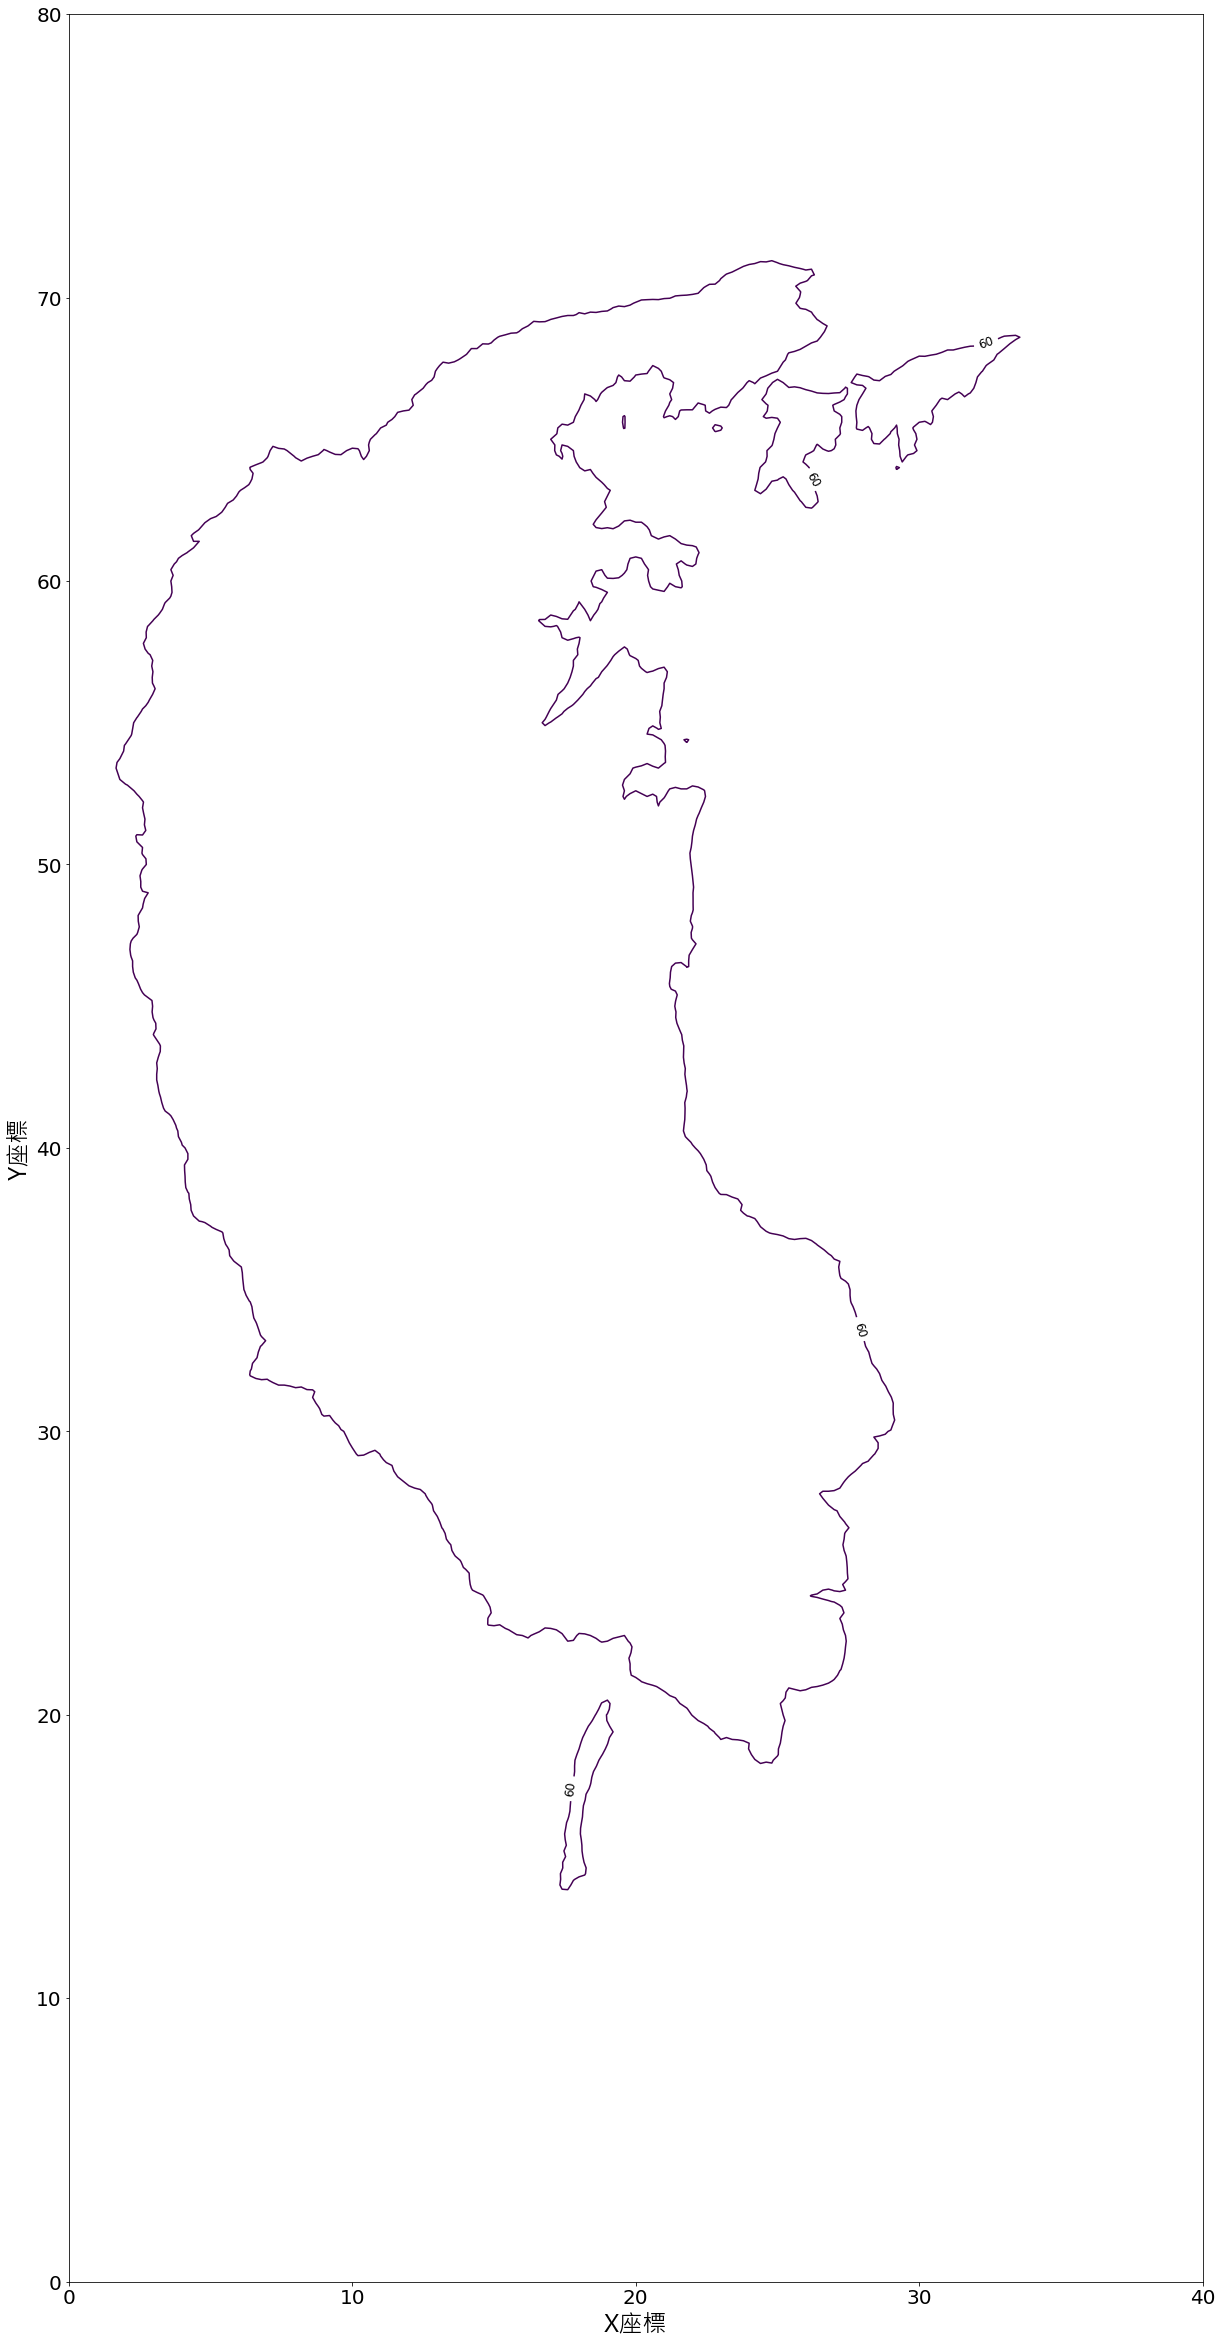

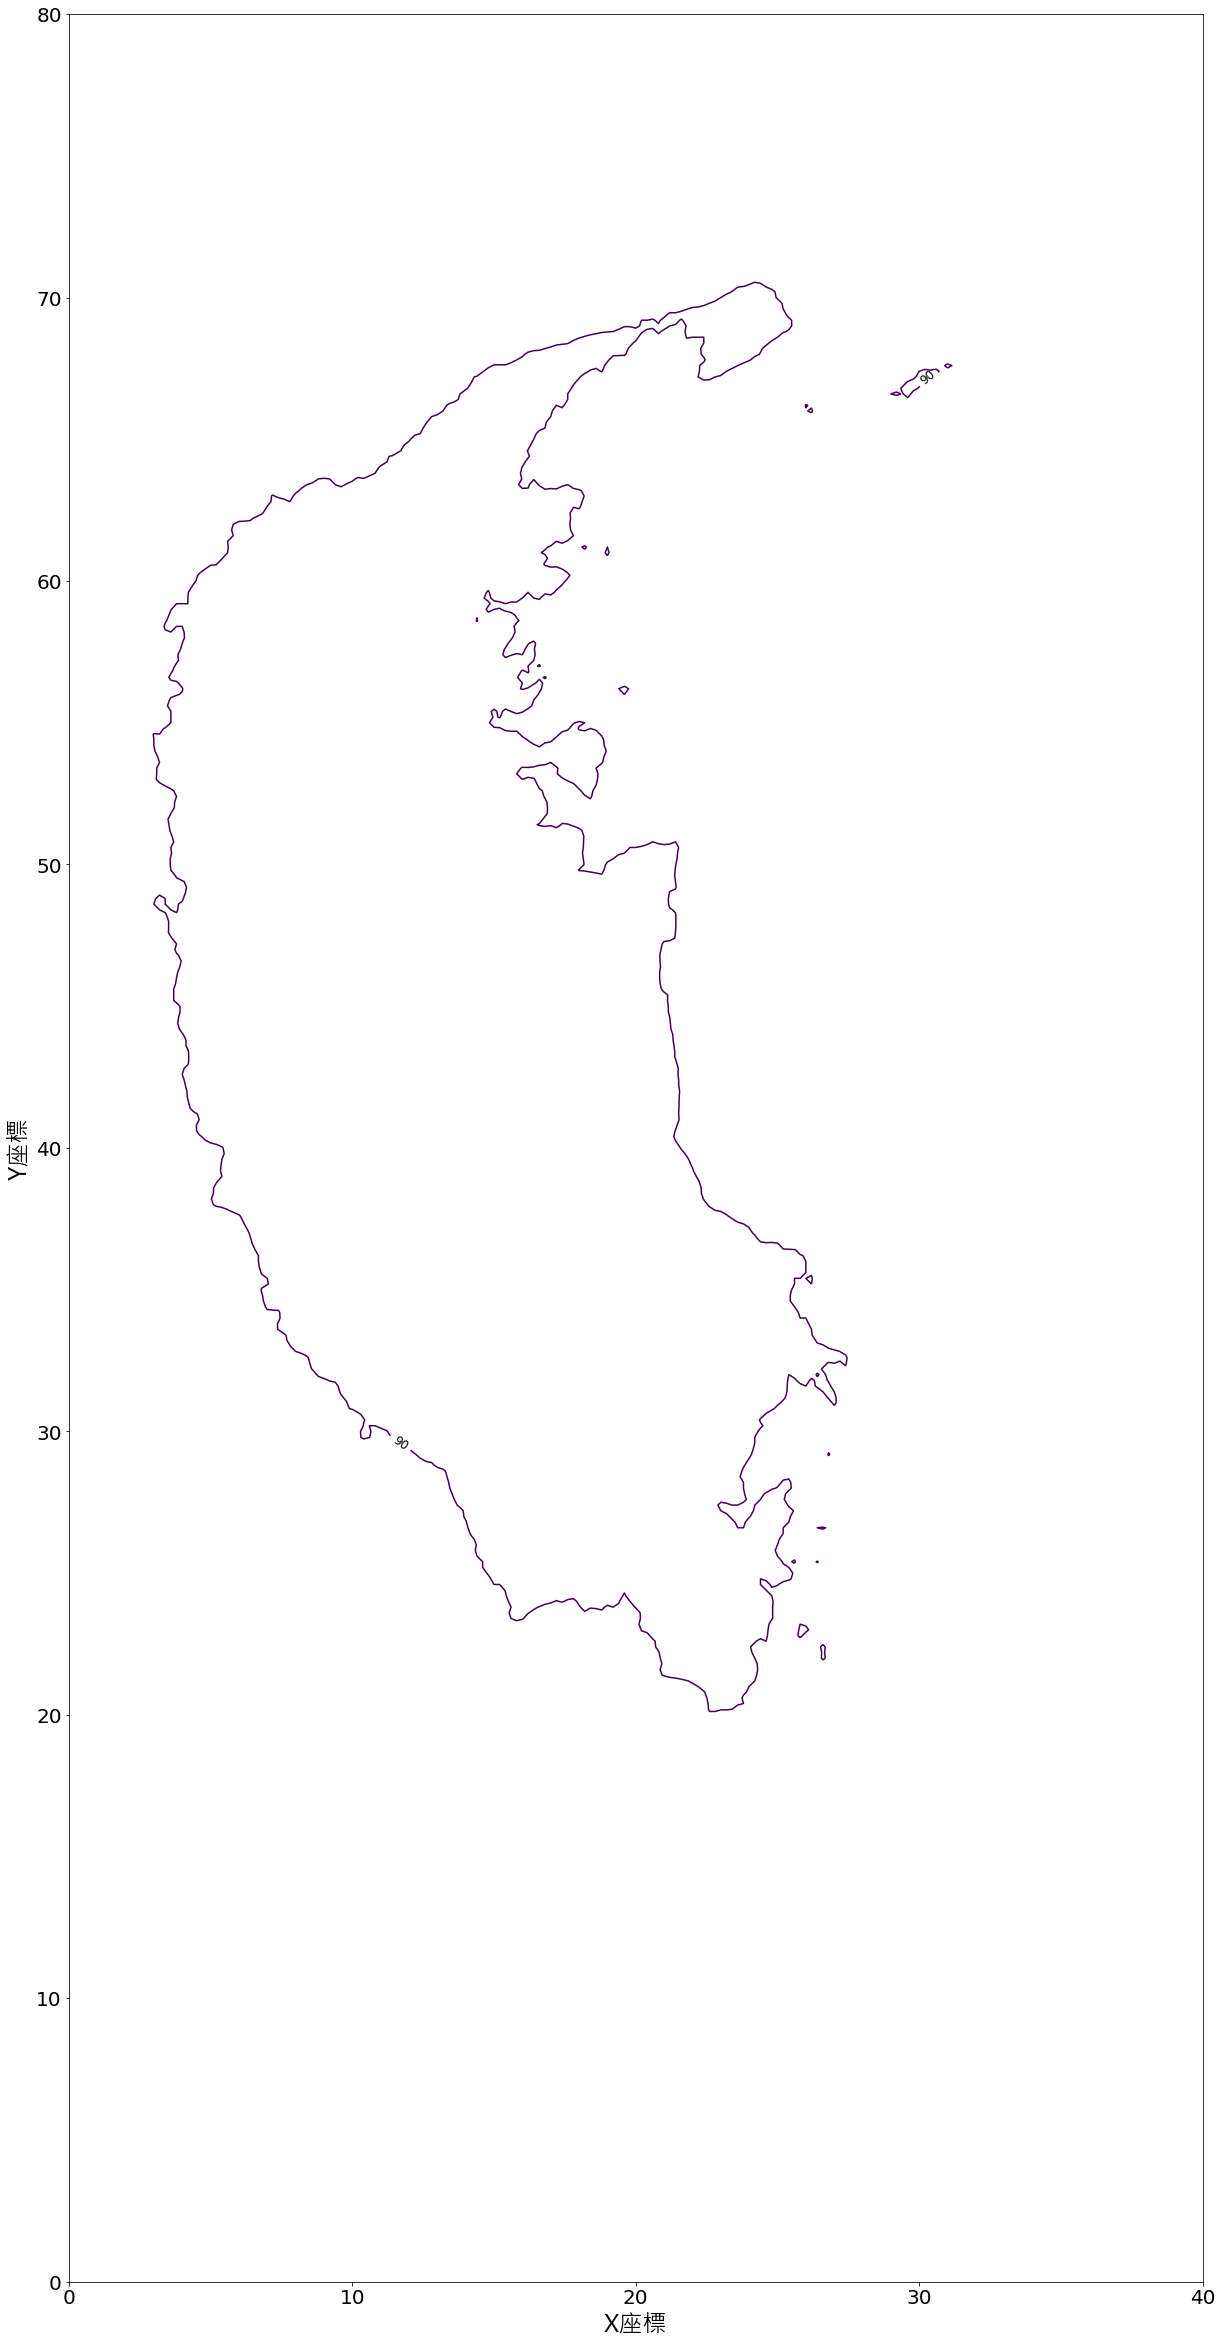

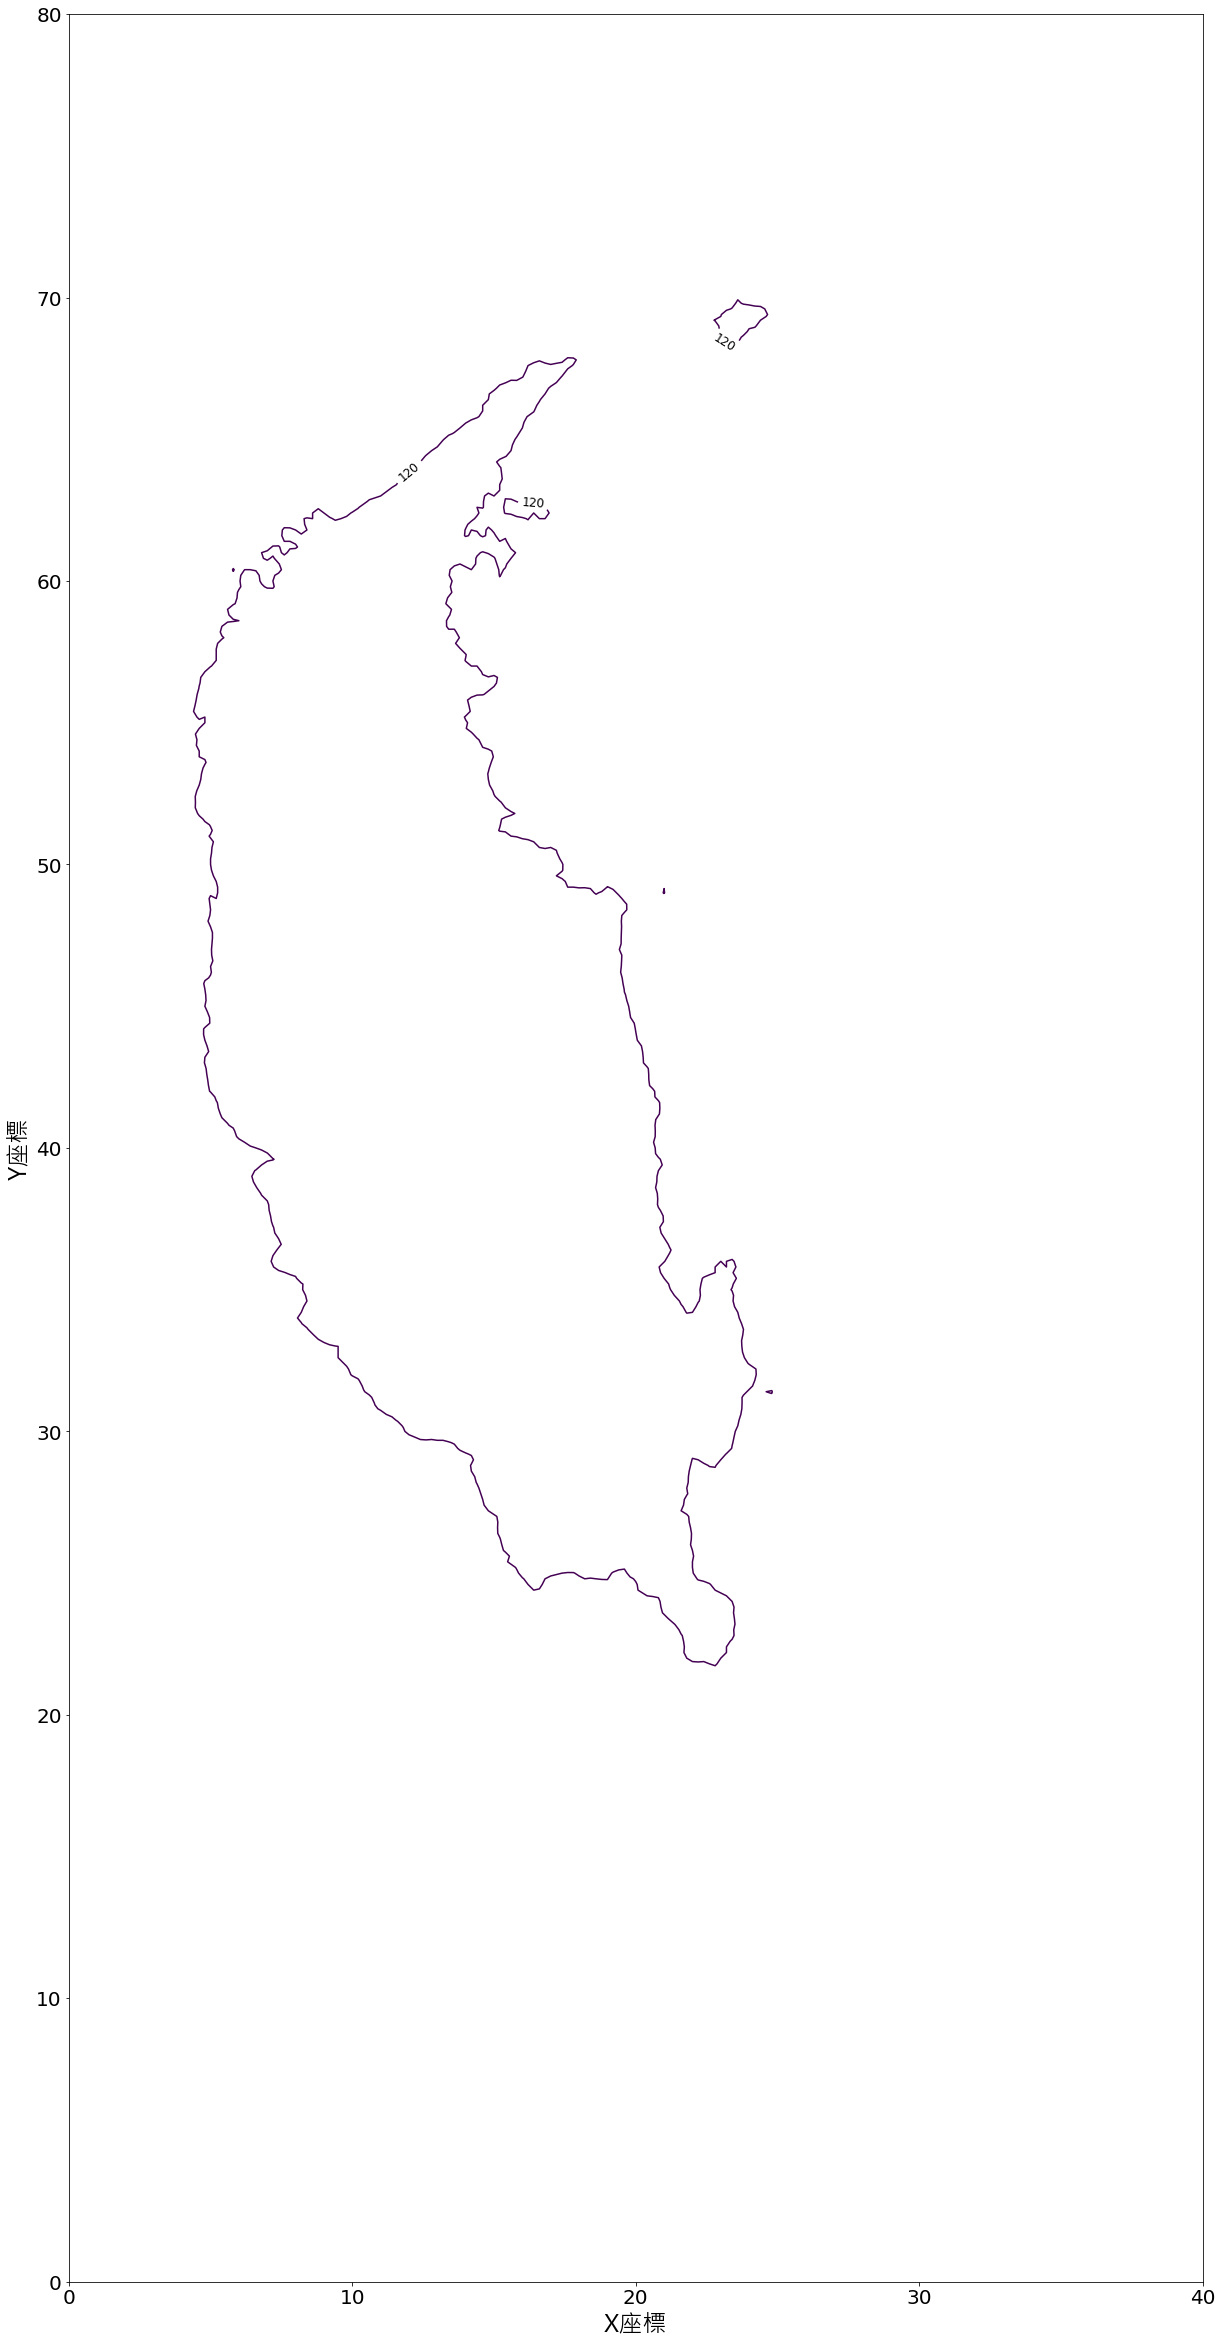

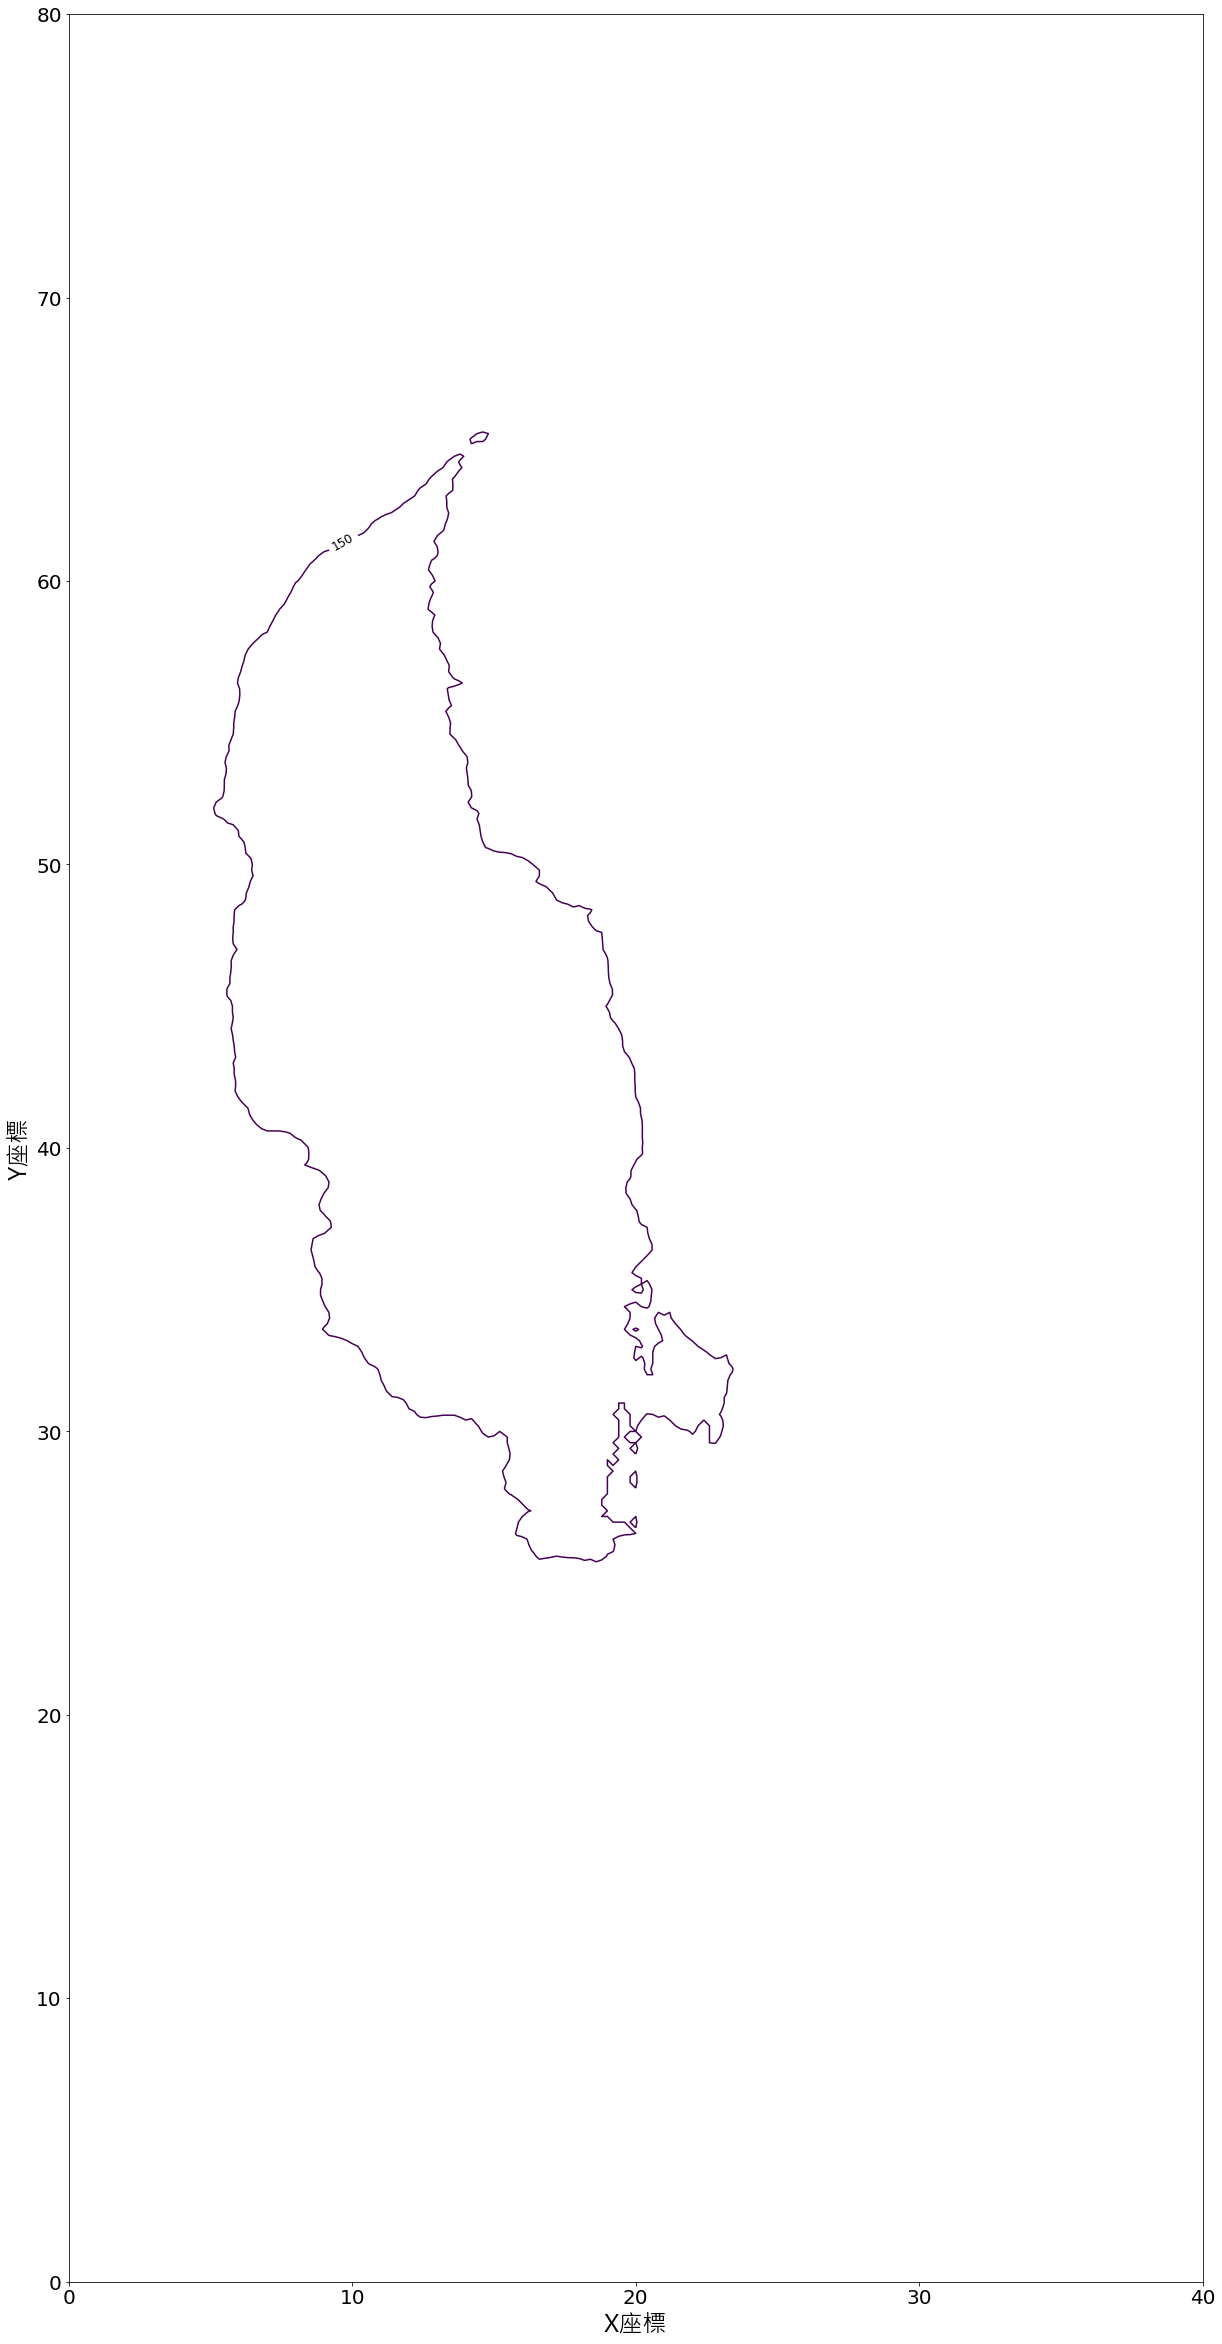

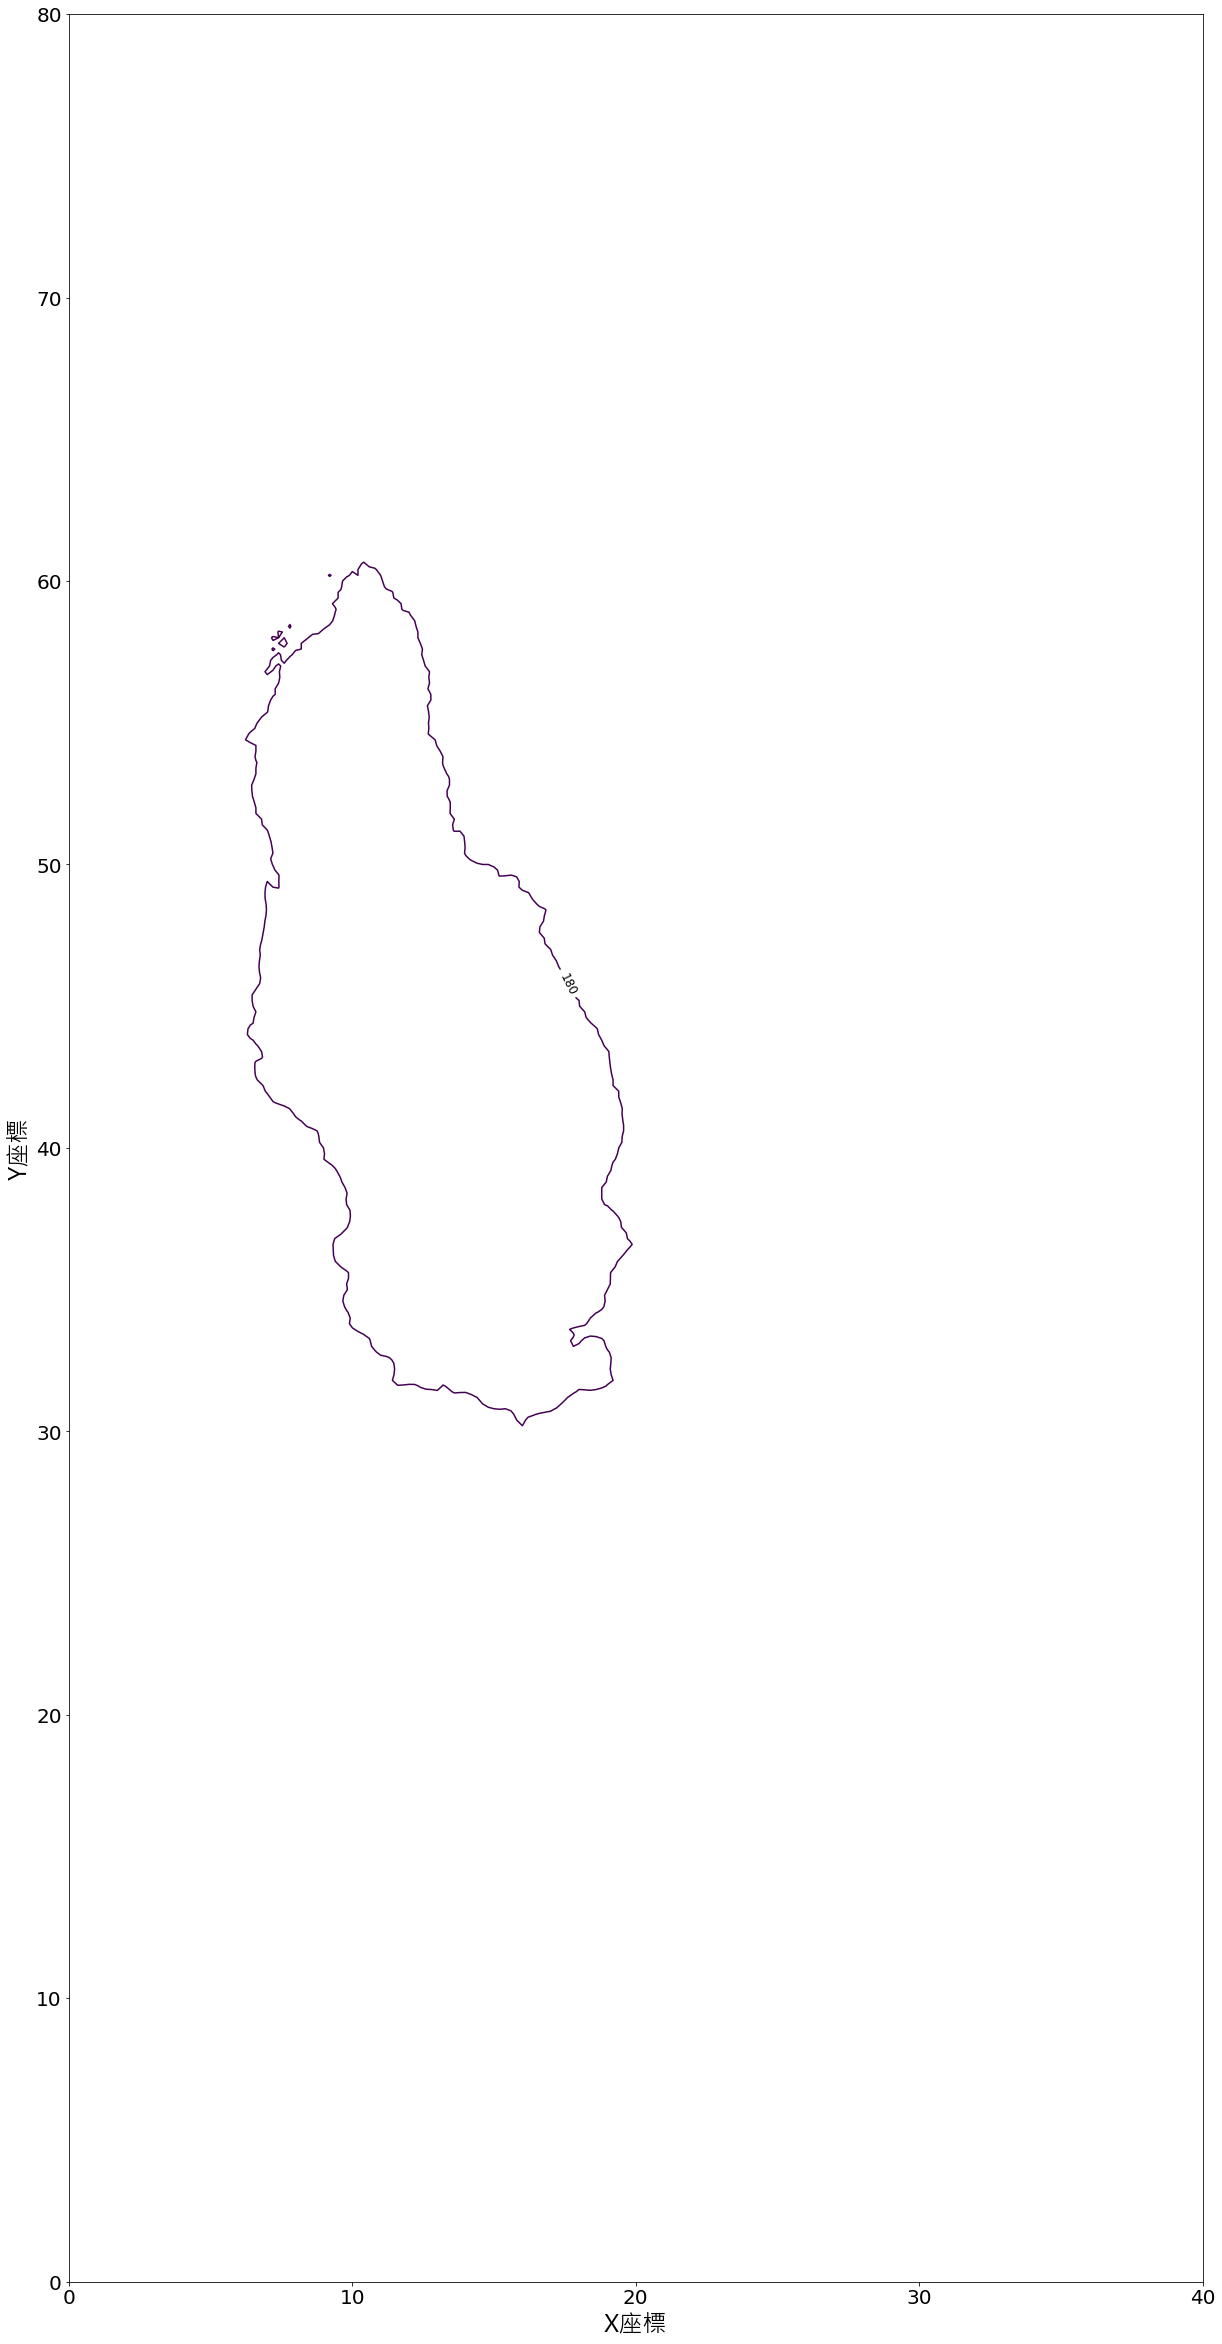

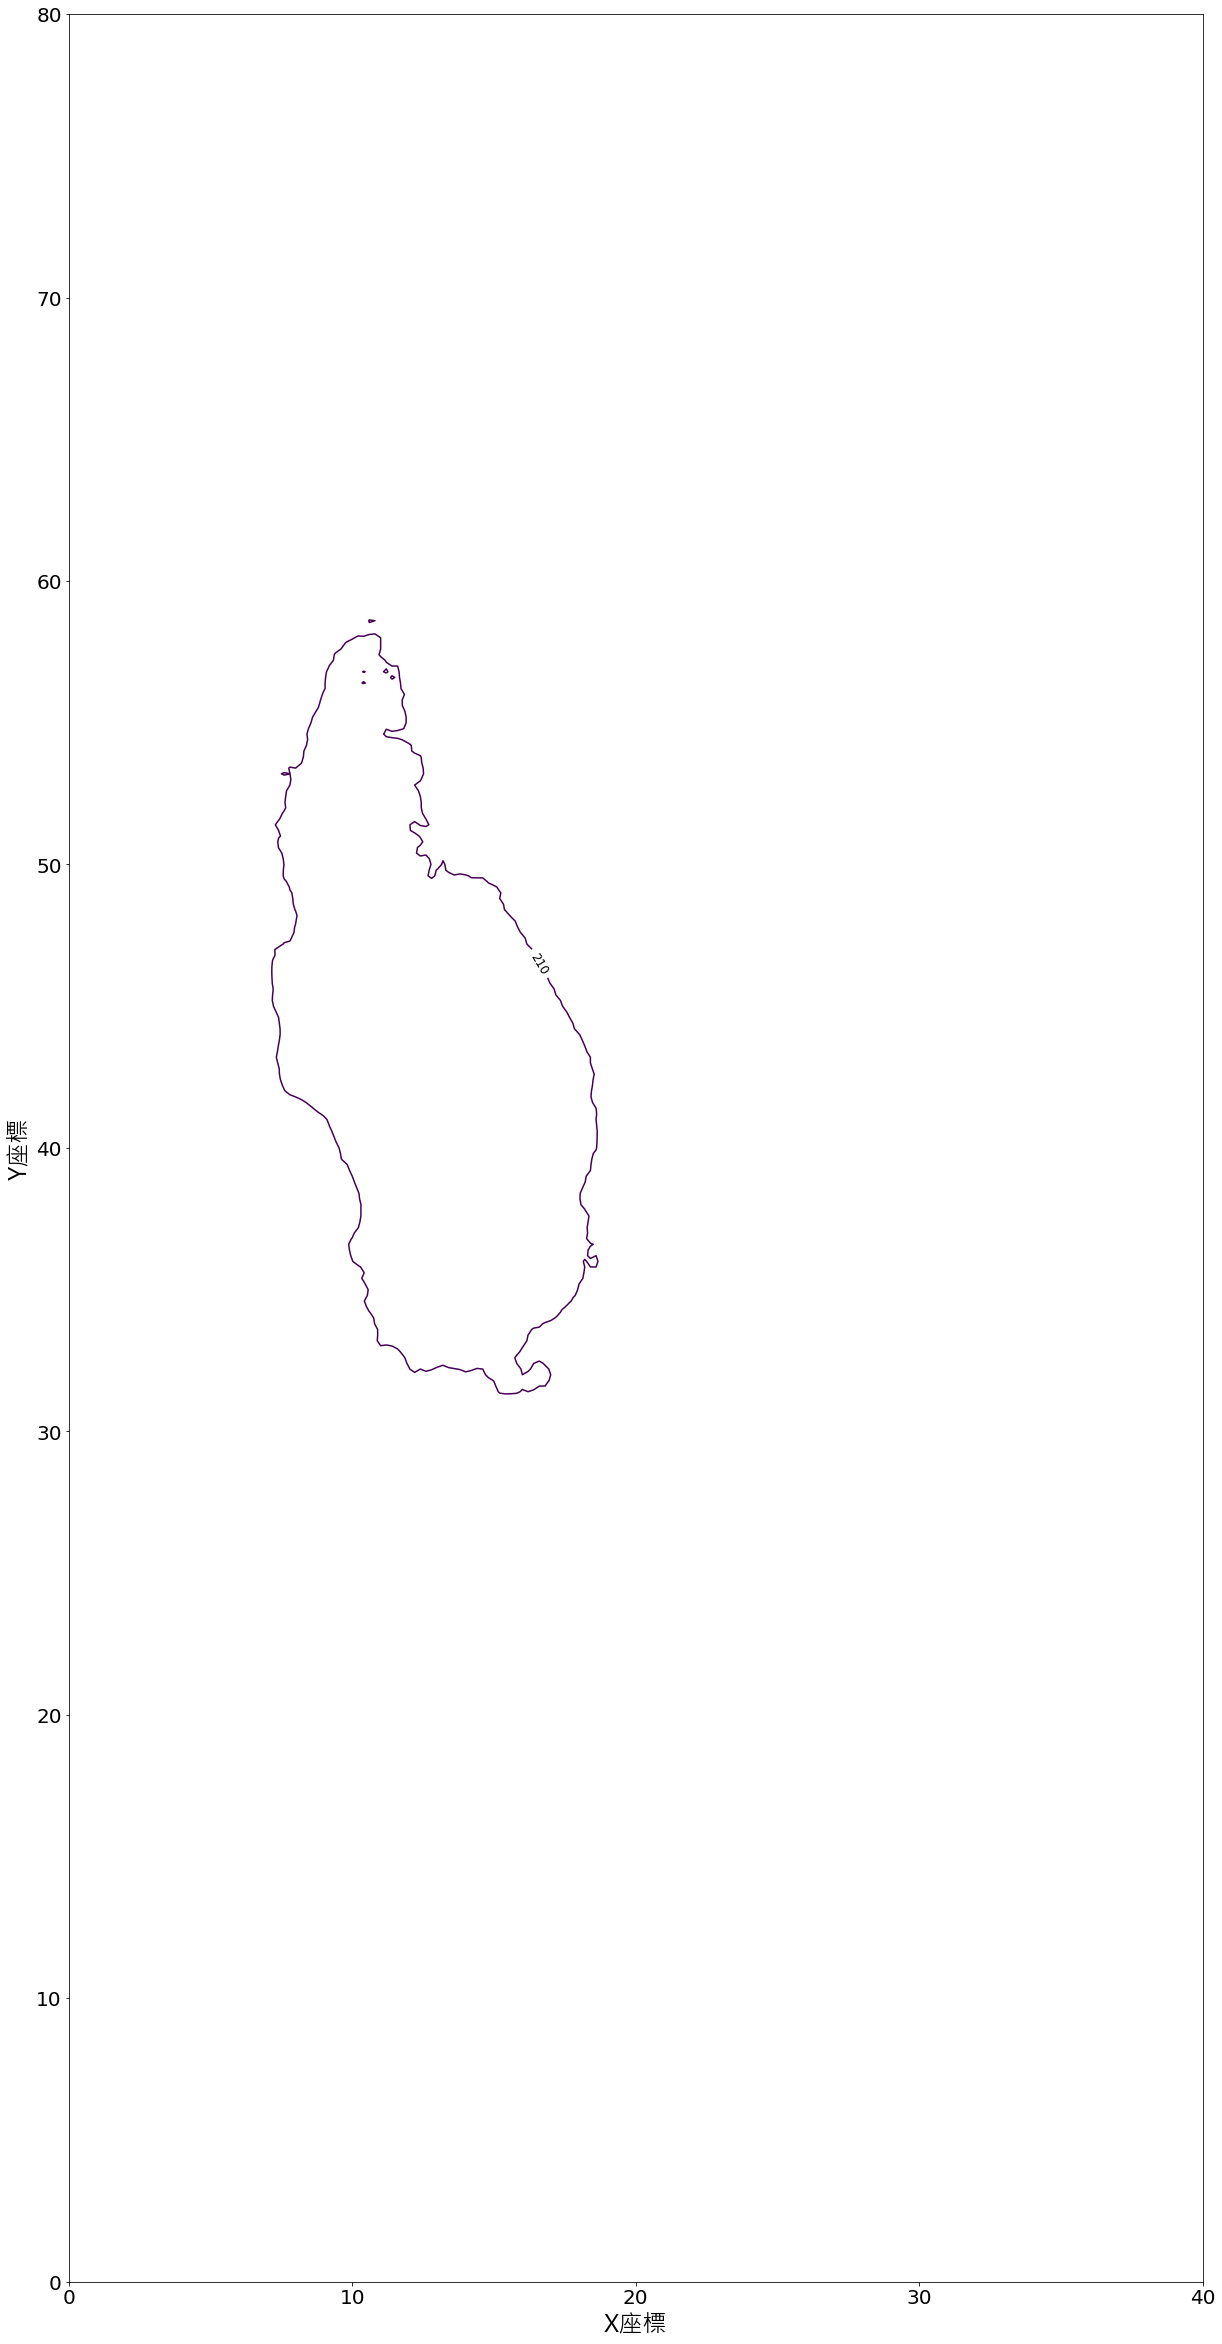

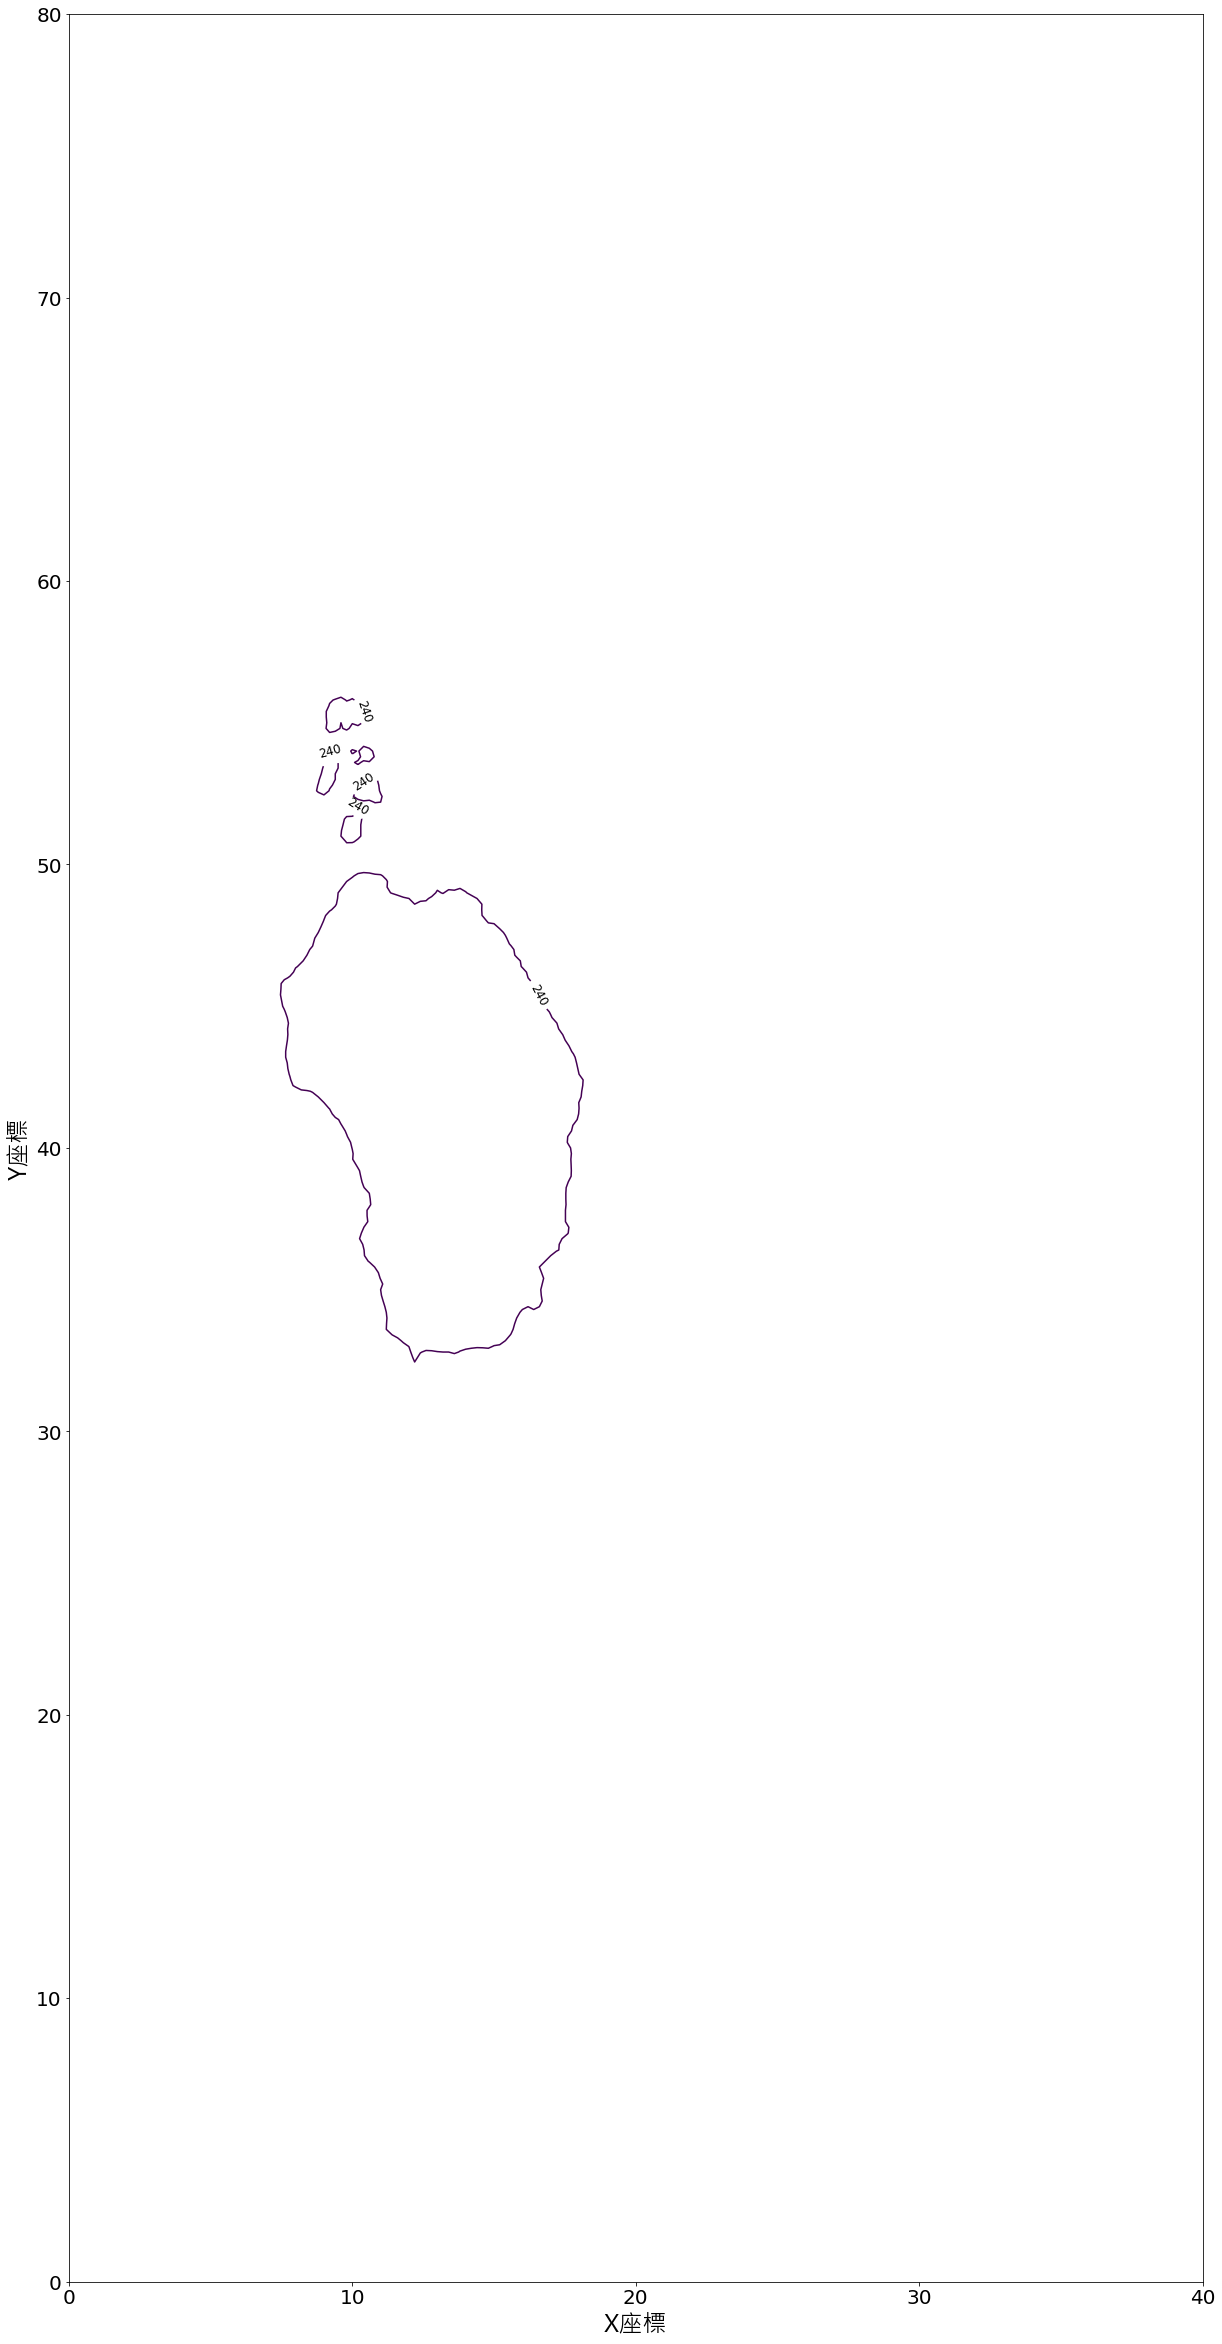

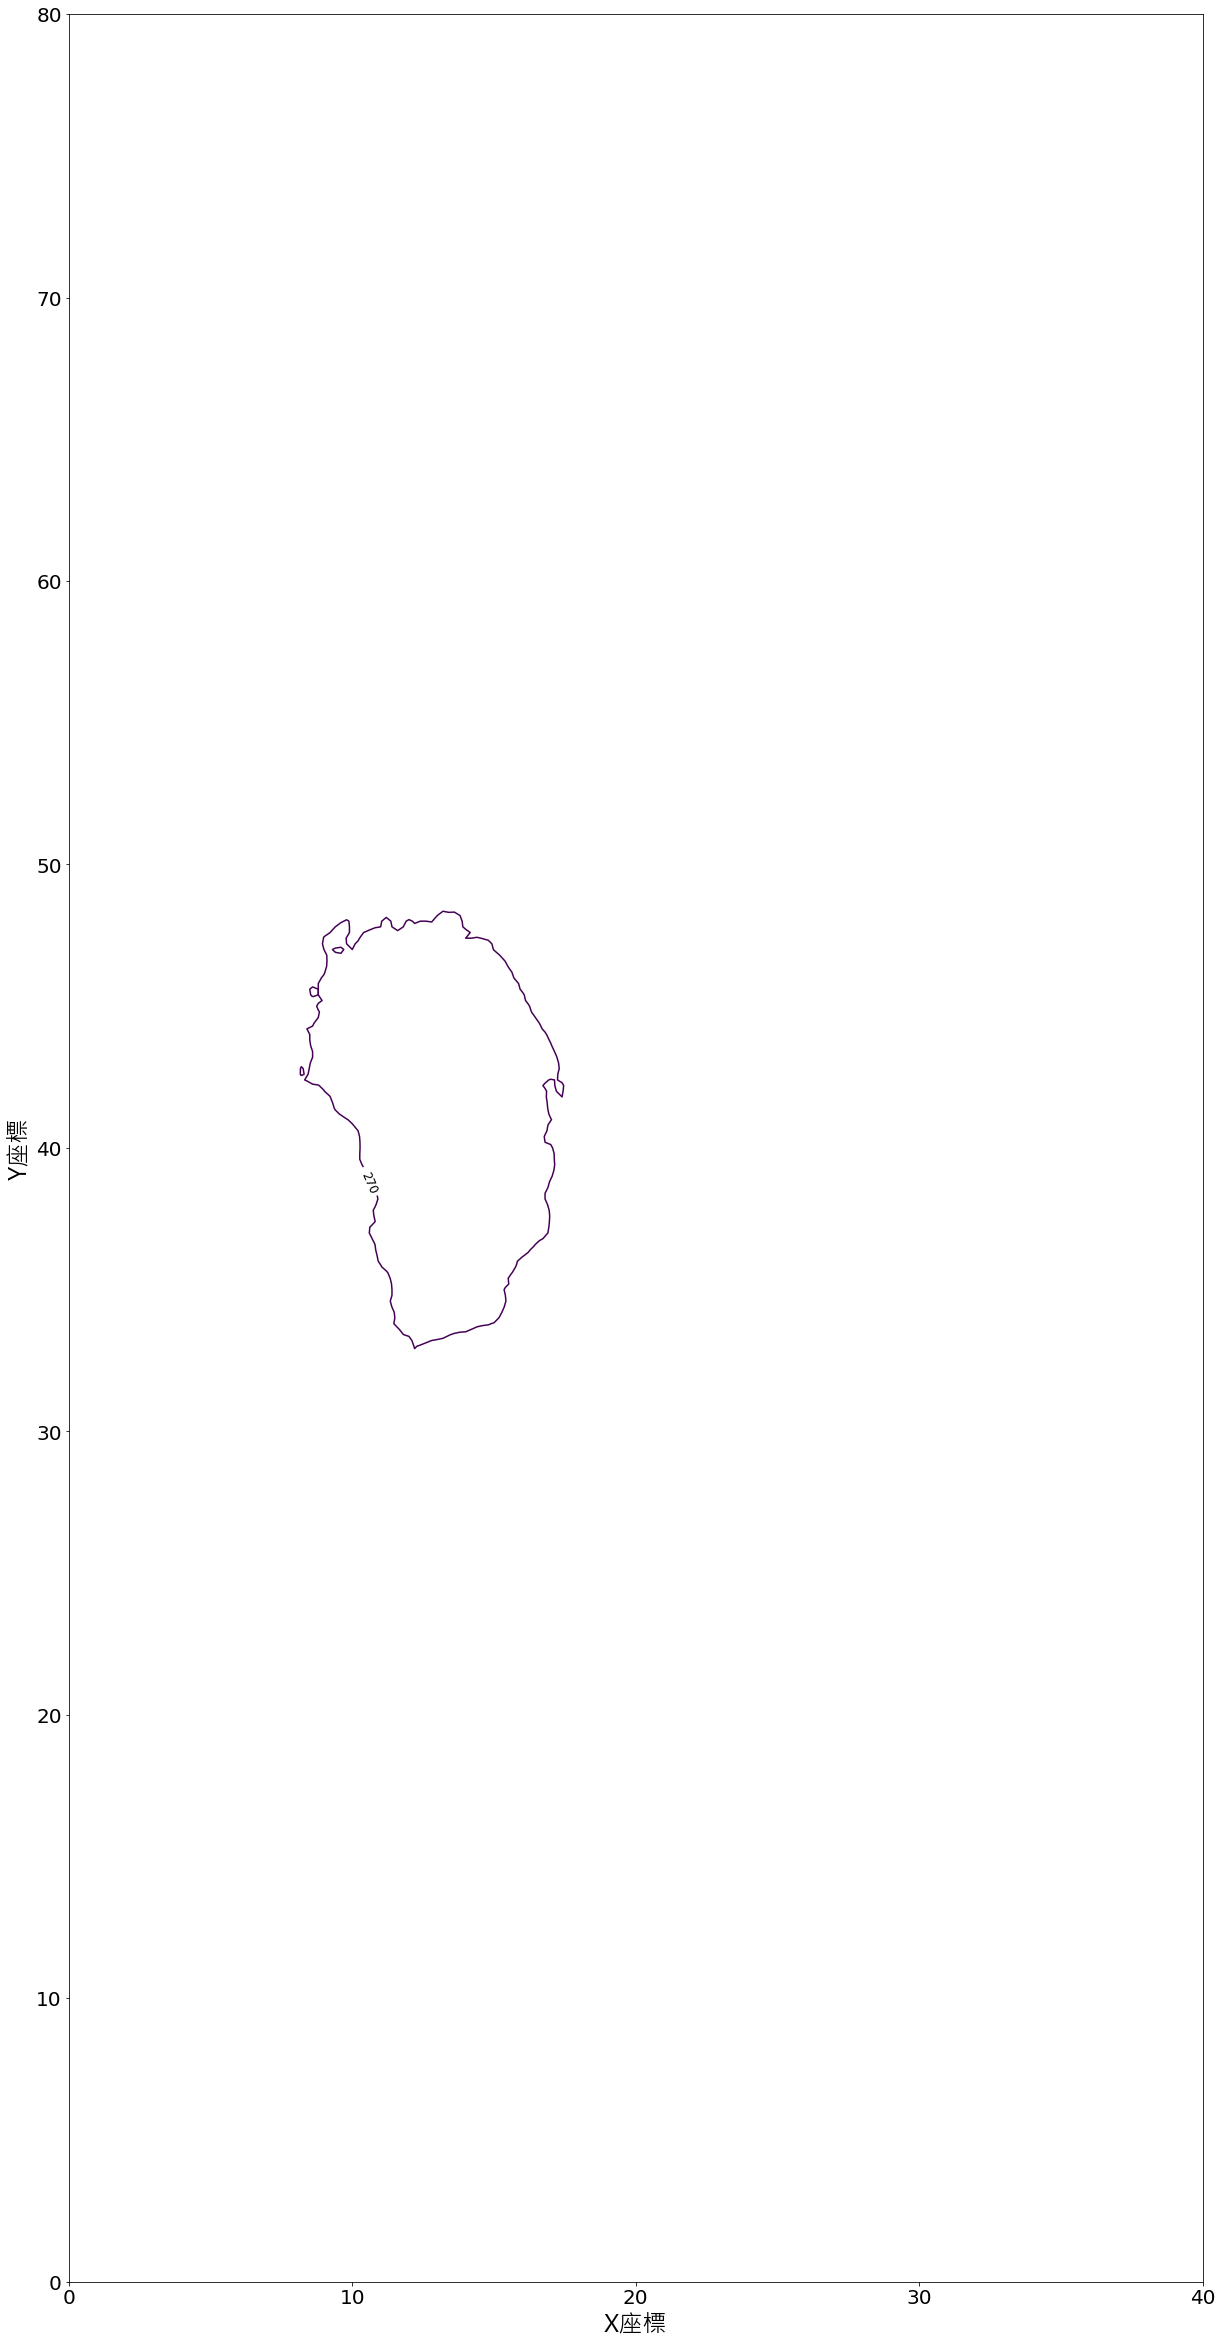

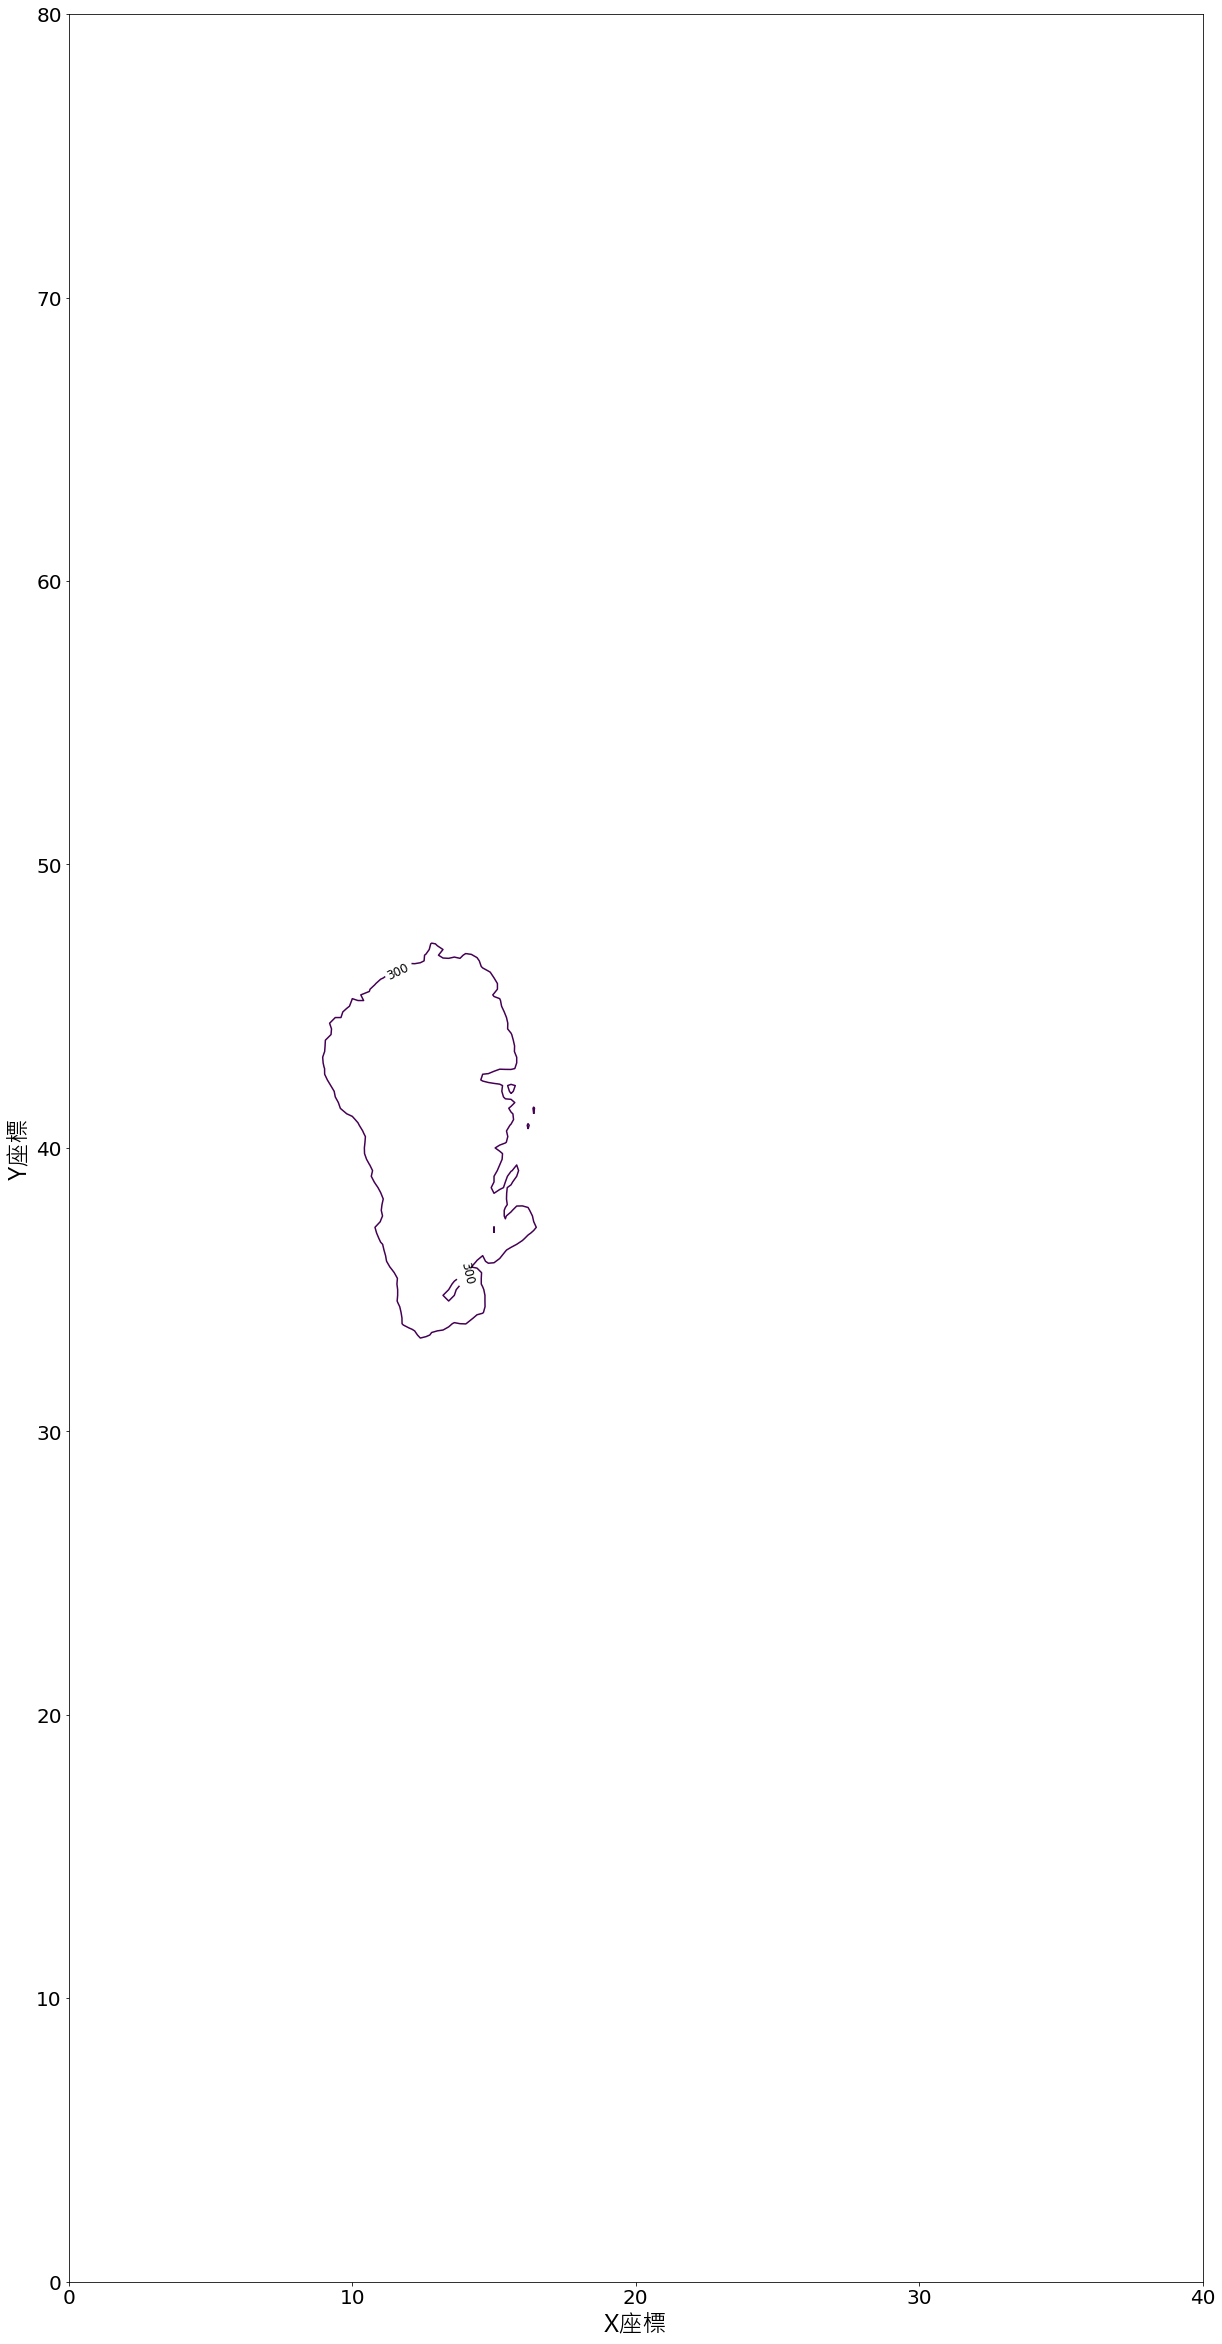

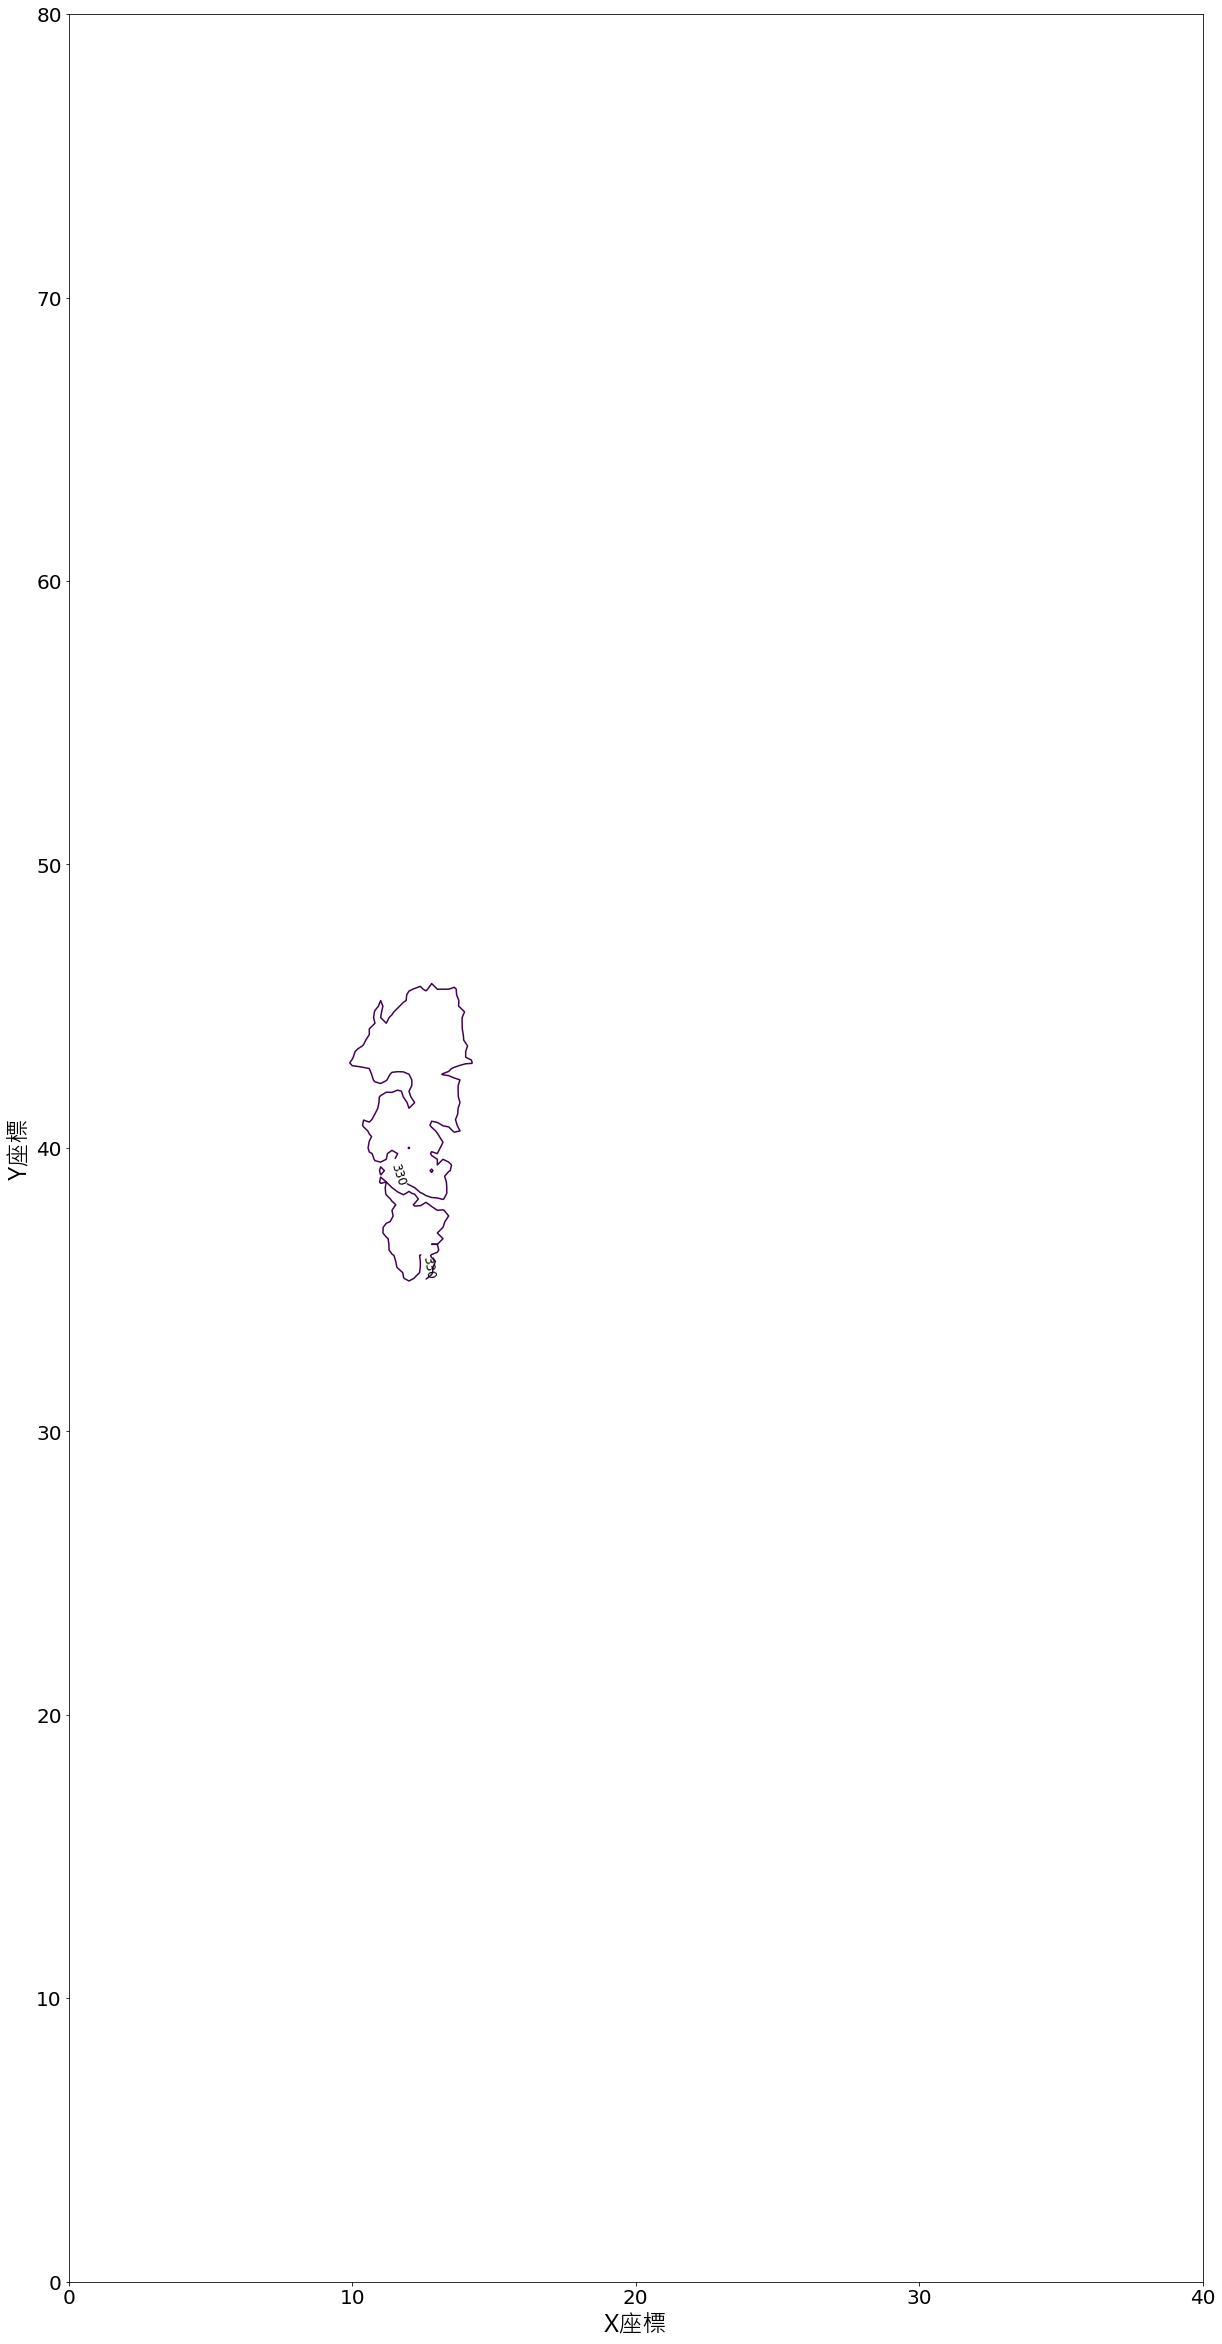

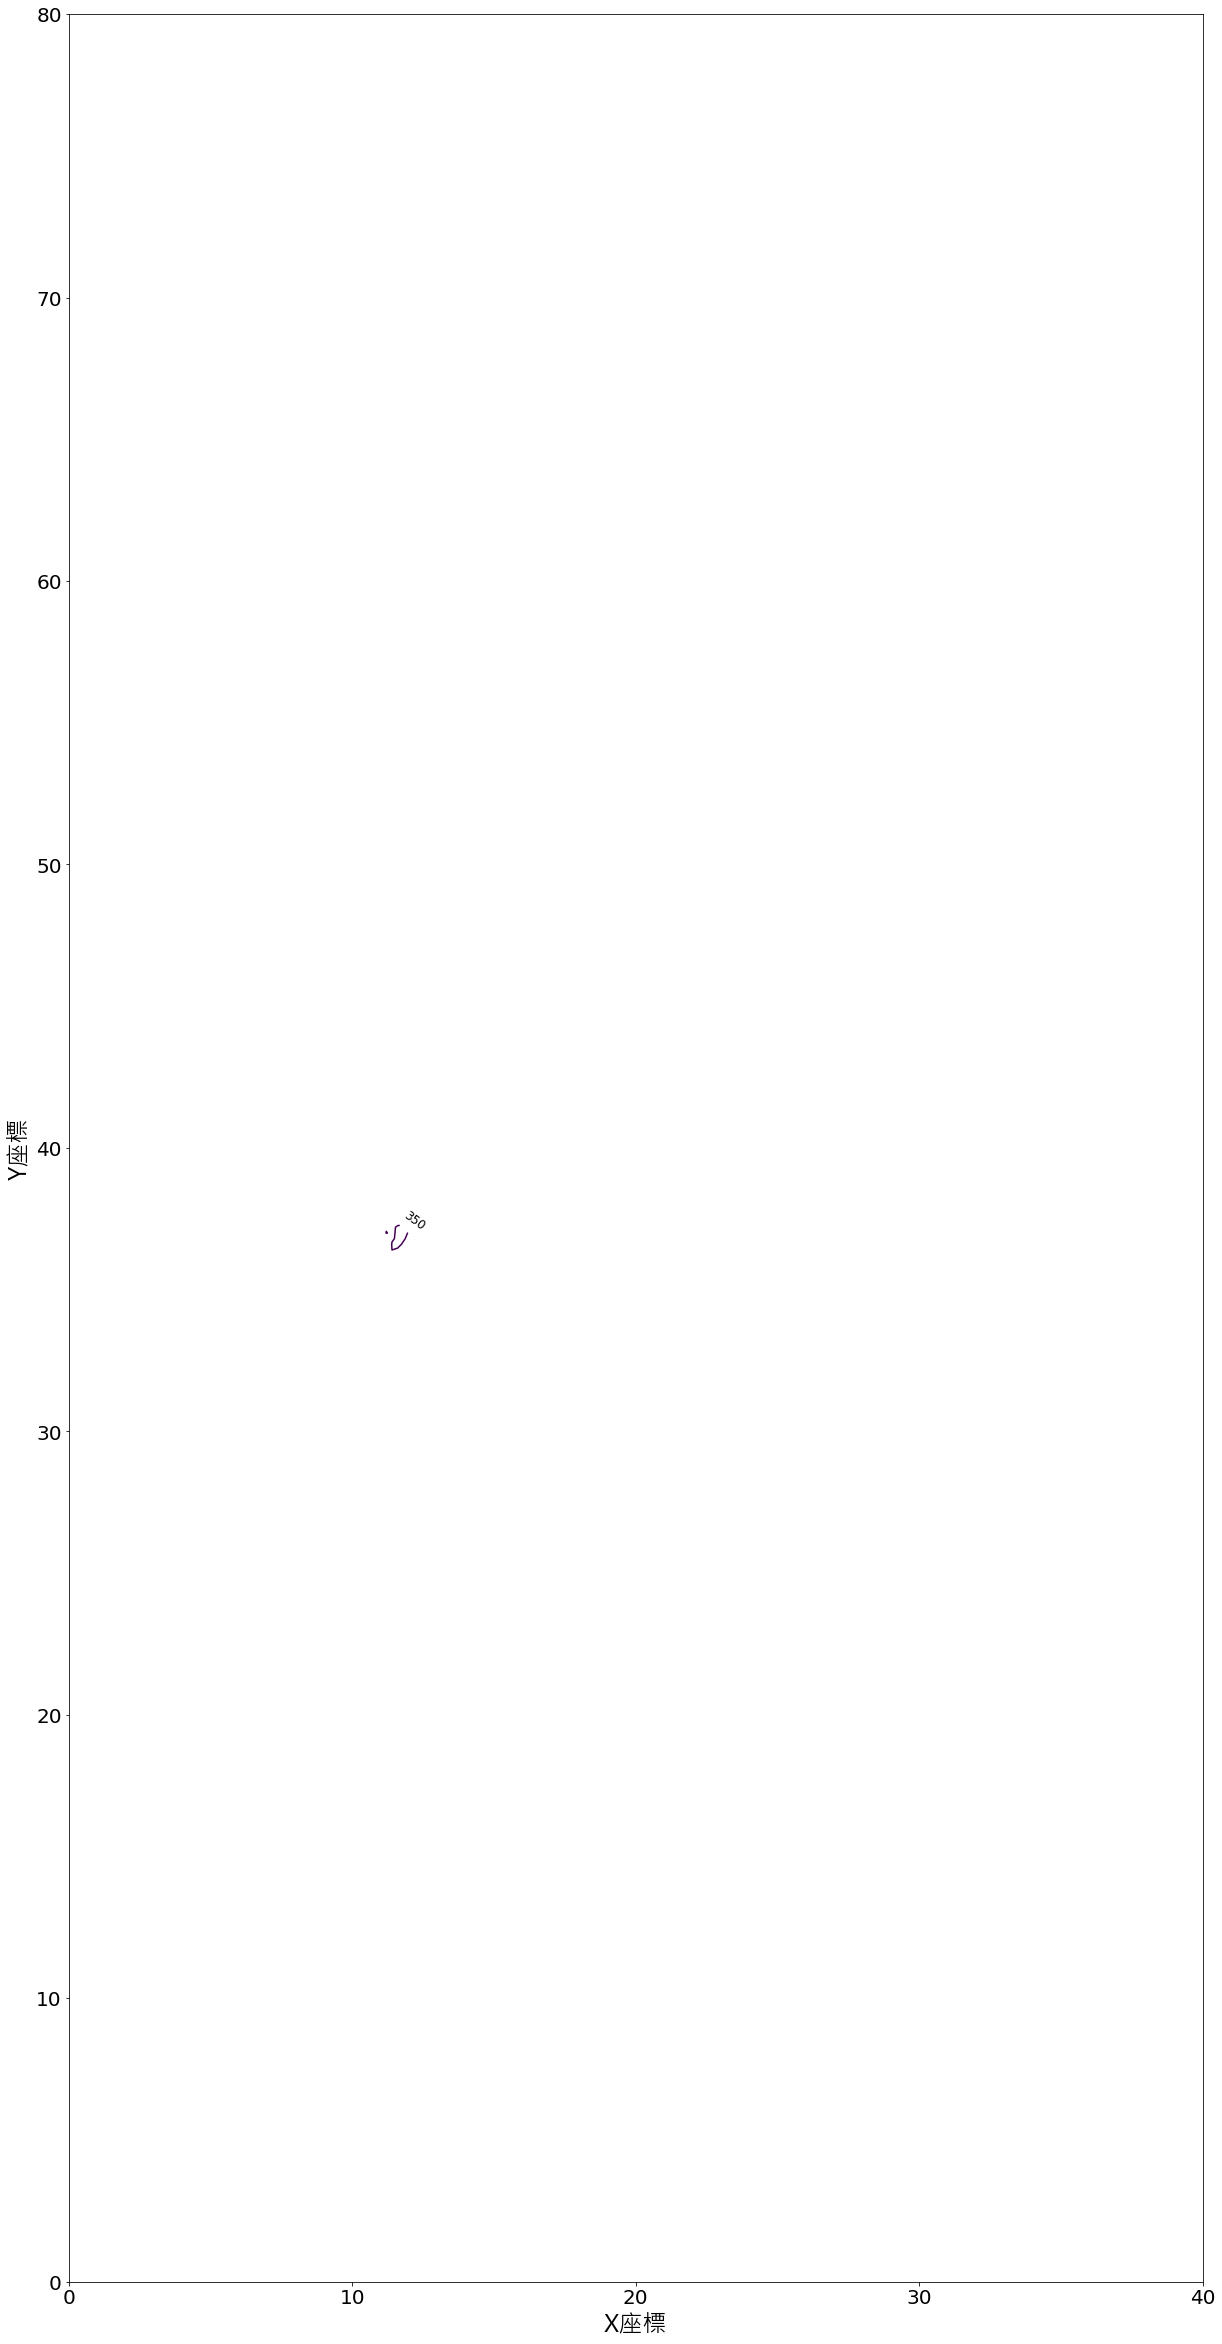

2021-11-19 04:43:23.259096
done


In [5]:
# ASSNP-11.py
# 2021-11-18
#
# Matplotlib 不支持直接輸出内嵌3D對象的PDF文件
#
# run on myBinder.org JupyterLab
# 程式檔 path is '/home/jovyan/SSNP3D/2_dir'
# 資料檔 path is '/home/jovyan/SSNP3D/2_dir/data'
# 圖形檔 path is '/home/jovyan/SSNP3D/2_dir/graphic'
#
from datetime import datetime
dt = datetime.now()
print(dt)
#
import csv
import numpy as np
import pprint
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fontManager
#
from matplotlib import cm # colormap
#
import os
path = os.getcwd()
print('當前工作目錄 ==>', path)
#
def set_graphic_area(width,height) :
        
    cm2inch = 1/2.54    # inch per cm
    #
    # define graphic area
    
    #
    left_margin = 2.0   # cm
    right_margin = 2.0  # cm
    #
    figure_width  = width  # cm , from xmin to xmax
    figure_height = height # cm , from ymin to ymax
    #
    top_margin = 2.0    # cm
    bottom_margin = 2.0 # cm
    #
    box_width = left_margin + figure_width + right_margin   # cm
    box_height = top_margin + figure_height + bottom_margin # cm
    #
    top_value    = 1.0 - top_margin / box_height
    bottom_value = bottom_margin / box_height
    left_value   = left_margin / box_width
    right_value  = 1.0 - right_margin / box_width
    #
    return (box_width*cm2inch,box_height*cm2inch,top_value,bottom_value,left_value,right_value,width)
#
# end of def
#
def new_plot_setting() :
    tup7 = set_graphic_area(40,80) # x, y 數值要相同, 不然地形圖會變形
    #
    fig = plt.figure(figsize=(tup7[0], tup7[1]))
    # ax  = fig.add_subplot(1,1,1, projection='3d')
    ax  = fig.add_subplot(1,1,1)
    fig.subplots_adjust(
                top    = tup7[2] ,
                bottom = tup7[3] ,
                left   = tup7[4] ,
                right  = tup7[5] ,
                )
    #
    plt.xlabel('X座標', fontproperties=myfont, fontsize=24)
    plt.ylabel('Y座標', fontproperties=myfont, fontsize=24)
    #
    plt.xlim(0, 40)    # xlim, ylim, need to be same
    plt.ylim(0, 80)    
    #
    x_ticks = np.linspace(0,40,5)
    y_ticks = np.linspace(0,80,9)
    #
    plt.xticks(x_ticks, fontsize=20)
    plt.yticks(y_ticks, fontsize=20)
    #
    plt.grid(False)
    plt.gca().set_aspect('equal', adjustable='box') # set X,Y same ratio & scale
# end def
#
path_data    = './data/'
path_graphic = './graphic/'
matplotlib.rcParams['pdf.fonttype'] = 42
myfont = fontManager.FontProperties(fname='/home/jovyan/fonts/msjh.ttc')
#
# -------------------------------------------------------------------------------
#
tup7 = set_graphic_area(40,80) # x, y 數值要相同, 不然地形圖會變形
#
fig = plt.figure(figsize=(tup7[0], tup7[1]))
# ax  = fig.add_subplot(1,1,1, projection='3d')
ax  = fig.add_subplot(1,1,1)
fig.subplots_adjust(
                top    = tup7[2] ,
                bottom = tup7[3] ,
                left   = tup7[4] ,
                right  = tup7[5] ,
                )
#
plt.xlabel('X座標', fontproperties=myfont, fontsize=24)
plt.ylabel('Y座標', fontproperties=myfont, fontsize=24)
#
plt.xlim(0, 40)    # xlim, ylim, need to be same
plt.ylim(0, 80)    
#
x_ticks = np.linspace(0,40,5)
y_ticks = np.linspace(0,80,9)
#
plt.xticks(x_ticks, fontsize=20)
plt.yticks(y_ticks, fontsize=20)
#
plt.grid(False)
plt.gca().set_aspect('equal', adjustable='box') # set X,Y same ratio & scale
#
# --------------------------------------------------------------------------
#
# 逐筆讀入資料 dem-all-7.csv
# Read from the file into the array data(:,:)
# array data shape is (...., 3)
#
# Columns:
# data[..., 0] is array of float number
# data[..., 1] is array of float number
# data[..., 2] is array of float number
#
# 台灣橫麥卡托二度分帶投影座標系統（TM2）
#
float_To_int = np.vectorize(np.int32)
#
data2 = np.loadtxt(path_data + 'dem-all-7.csv',delimiter=',',dtype='float')
min_item = np.amin(data2, axis=0) # axis=0 --> min of each column
max_item = np.amax(data2, axis=0) # axis=0 --> max of each column
print ('Left Down point:', float_To_int(min_item[0]), float_To_int(min_item[1]))
print ('Right Up point: ' , float_To_int(max_item[0]), float_To_int(max_item[1]))
print ('height (min, max)', min_item[2], max_item[2])
print ('\n')
#
# Left Down point: 0, 0
# Right Up point:  4000, 7800
# height (min, max) 0, 357.21
#
TM2_X = float_To_int(data2[..., 0]) # 二度分帶 X座標
TM2_Y = float_To_int(data2[..., 1]) # 二度分帶 Y座標
TM2_Z = data2[..., 2]               # DEM file z value, float type
#
# XYlist is sorted (x, y), first order is y, then x
#
XYlist = list(zip(TM2_X,TM2_Y))
#
# X, Y value
X = np.arange(0, 4020, 20)
Y = np.arange(0, 7820, 20)
Xmesh, Ymesh = np.meshgrid(X, Y)  # x-y 平面的網格
#
# pprint.pprint(Xmesh[-1])
print ('\n')
# pprint.pprint(Ymesh[-1])
print ('\n')
#
# 7800/20 ==> 391
# 4020/20 ==> 201
Zmesh = np.zeros(shape=(391,201),dtype=np.float16)
i = 0
j = 0
#
for y in np.arange(0, 7820, 20) :
    print('y is', y)
    z = np.zeros(shape=(201),dtype=np.float16)
    zi = 0
    for x in np.arange(0, 4020, 20):
        if (x,y) in XYlist :
            # print(str(zi), list([x,y]), TM2_Z[i])
            z[zi] = TM2_Z[i]
            i = i + 1
        else :
            # print(str(zi))
            z[zi] = 0.0
        # end if
        zi = zi + 1
    #end for
    # pprint.pprint(z)
    Zmesh[j] = z
    j = j + 1
#end for
print ('\n')
# pprint.pprint(Zmesh[-1])
#
factor_3D = 0.01
Xmesh_3D = factor_3D * Xmesh
Ymesh_3D = factor_3D * Ymesh
Zmesh_3C = np.around(Zmesh)
Zmesh_3D = Zmesh_3C.astype(int)
#
# two option, 15 or 18
# levels
# Determines the number and positions of the contour lines
# If an int n which tries to automatically choose no more than n+1 "nice" contour levels between vmin and vmax.
# If array-like, draw contour lines at the specified levels. The values must be in increasing order.
#
levels = (15,30,60,90,120,150,180,210,240,270,300,330,350)
i = 0
for level in levels : 
    i = i + 1
    if len(str(level)) == 2 :
        str_level = '0' + str(level)
    else :
        str_level = str(level)
    # end if
    #
    contour_set = plt.contour(Xmesh_3D, Ymesh_3D, Zmesh_3D, [level]) 
    plt.clabel(contour_set, inline=True, colors='black', fontsize=12, fmt='%d')
    ax.set_title('ASSNP-11 台灣橫麥卡托二度分帶投影座標系統（TM2）', fontproperties=myfont, fontsize=24)
    # plt.savefig(path_graphic + "ASSNP-dem-" + str_level + "-line.png", format="png",dpi=100, bbox_inches='tight')
    plt.savefig(path_graphic + "ASSNP-dem-" + str_level + "-label.png", format="png",dpi=100, bbox_inches='tight')
    plt.show()
    #
    if i < len(levels) :
        new_plot_setting()
    # end if
# end for
# --------------------------------------------------------------------------
#
dt = datetime.now()
print(dt)
print('done')